In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [87]:
pd.set_option('display.max_columns', 500)

## Unión de bases de datos
En esta sección se unirán las diferentes bases de datos en una sola. Para ello se utilizará la función `merge` de la librería `pandas`. Los merge se harán sobre el archivo de `Info_Matriculados_Anon.parquet`, debido a que en este es donde tenemos los estudiantes matriculados cada semestre.

### Archivo Info_Matriculados_Anon.parquet

Se abre el archivo principal: `Info_Matriculados_Anon.parquet`

In [88]:
info_matriculados = pd.read_parquet("Info_Matriculados_Anon.parquet")
info_matriculados

,PERIODO,MATRICULADO_PERIODO_ACTUAL,EDAD,TIPO_ESTADO_CIVIL,NACIONALIDAD,CODIGO_NIVEL_PROGRAMA_1,NIVEL_PROGRAMA_1,CODIGO_FACULTAD_PROGRAMA_1,FACULTAD_PROGRAMA_1,CODIGO_DEPARTAMENTO_PROGRAMA_1,DEPARTAMENTO_PROGRAMA_1,CODIGO_PROGRAMA_1,PROGRAMA_1,CODIGO_NIVEL_PROGRAMA_2,NIVEL_PROGRAMA_2,CODIGO_FACULTAD_PROGRAMA_2,FACULTAD_PROGRAMA_2,CODIGO_DEPARTAMENTO_PROGRAMA_2,DEPARTAMENTO_PROGRAMA_2,CODIGO_PROGRAMA_2,PROGRAMA_2,CODIGO_NIVEL_PROGRAMA_3,NIVEL_PROGRAMA_3,CODIGO_FACULTAD_PROGRAMA_3,FACULTAD_PROGRAMA_3,CODIGO_DEPARTAMENTO_PROGRAMA_3,DEPARTAMENTO_PROGRAMA_3,CODIGO_PROGRAMA_3,PROGRAMA_3,DESC_ESTADO_ACADEMICO,CODIGO_ESTUDIANTE_ANON
0,201720,SI,46.0,SOLTERO,COLOMBIANO,MA,MAGISTER,CD,CIDER,CIDE,CENTRO INTERD.ESTUDIOS DESARR.,M-EDES,MAESTRIA EN ESTUD.INTER.DESARR,,None,,None,,None,,None,,None,,None,,None,,None,NORMAL,db195bc7d5
1,201720,SI,44.0,SOLTERO,COLOMBIANO,MA,MAGISTER,HU,CIENCIAS SOCIALES,CPOL,CIENCIA POLITICA,M-CPOL,MAESTRIA EN CIENCIA POLITICA,,None,,None,,None,,None,,None,,None,,None,,None,REINTEGRO,d708c0c540
2,201720,SI,39.0,CASADO,COLOMBIANO,MA,MAGISTER,AD,ADMINISTRACIÓN,ADMI,ADMINISTRACION,M-MBAT,MAESTRIA ADMINISTRACION-MBA-TC,,None,,None,,None,,None,,None,,None,,None,,None,NORMAL,234b8b064c
3,202210,SI,29.0,None,COLOMBIANO,MA,MAGISTER,IN,INGENIERÍA,IIND,INGENIERIA INDUSTRIAL,M-IIND,MAESTRIA EN ING.INDUSTRIAL,,None,,None,,None,,None,,None,,None,,None,,None,NORMAL,11c8bf67b0
4,201720,SI,49.0,DIVORCIADO,COLOMBIANO,MA,MAGISTER,ED,EDUCACIÓN,CIFE,CENTRO INVESTIG.FORMAC.EDUCAC.,M-EDUC,MAESTRIA EN EDUCACION,,None,,None,,None,,None,,None,,None,,None,,None,NORMAL,16b83d214d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162620,200919,SI,43.0,SOLTERO,No Informa,MA,MAGISTER,AD,ADMINISTRACIÓN,ADMI,ADMINISTRACION,M-MATP,MAESTRIA EN ADMINISTRACION,,None,,None,,None,,None,,None,,None,,None,,None,NORMAL,0e25072988
162621,201015,SI,46.0,CASADO,COLOMBIANO,MA,MAGISTER,AD,ADMINISTRACIÓN,ADMI,ADMINISTRACION,M-MERC,MAESTRIA EN MERCADEO,,None,,None,,None,,None,,None,,None,,None,,None,PRIMER SEMESTRE POSTGRADO,9ae9134098
162622,201020,SI,39.0,CASADO,COLOMBIANO,MA,MAGISTER,EC,ECONOMÍA,ECON,ECONOMIA,M-ECON,MAESTRIA EN ECONOMIA,,None,,None,,None,,None,,None,,None,,None,,None,NORMAL,580f1c03a2
162623,201019,SI,45.0,SOLTERO,No Informa,MA,MAGISTER,AD,ADMINISTRACIÓN,ADMI,ADMINISTRACION,M-MERC,MAESTRIA EN MERCADEO,,None,,None,,None,,None,,None,,None,,None,,None,NORMAL,c49f4a2427


Se verifica que solo estemos tomando a los estudiantes matriculados

In [89]:
info_matriculados["MATRICULADO_PERIODO_ACTUAL"].unique()

array(['SI'], dtype=object)

Adicionalmente, para disminuir la complejidad del problema se decidió únicamente tomar el primer programa de cada estudiante y se toman las columnas de interés.

In [90]:
info_matriculados = info_matriculados[["PERIODO", "CODIGO_ESTUDIANTE_ANON", "EDAD", "TIPO_ESTADO_CIVIL", "NIVEL_PROGRAMA_1", "FACULTAD_PROGRAMA_1", "DEPARTAMENTO_PROGRAMA_1", "PROGRAMA_1", "CODIGO_PROGRAMA_1", "DESC_ESTADO_ACADEMICO"]]
info_matriculados

,PERIODO,CODIGO_ESTUDIANTE_ANON,EDAD,TIPO_ESTADO_CIVIL,NIVEL_PROGRAMA_1,FACULTAD_PROGRAMA_1,DEPARTAMENTO_PROGRAMA_1,PROGRAMA_1,CODIGO_PROGRAMA_1,DESC_ESTADO_ACADEMICO
0,201720,db195bc7d5,46.0,SOLTERO,MAGISTER,CIDER,CENTRO INTERD.ESTUDIOS DESARR.,MAESTRIA EN ESTUD.INTER.DESARR,M-EDES,NORMAL
1,201720,d708c0c540,44.0,SOLTERO,MAGISTER,CIENCIAS SOCIALES,CIENCIA POLITICA,MAESTRIA EN CIENCIA POLITICA,M-CPOL,REINTEGRO
2,201720,234b8b064c,39.0,CASADO,MAGISTER,ADMINISTRACIÓN,ADMINISTRACION,MAESTRIA ADMINISTRACION-MBA-TC,M-MBAT,NORMAL
3,202210,11c8bf67b0,29.0,None,MAGISTER,INGENIERÍA,INGENIERIA INDUSTRIAL,MAESTRIA EN ING.INDUSTRIAL,M-IIND,NORMAL
4,201720,16b83d214d,49.0,DIVORCIADO,MAGISTER,EDUCACIÓN,CENTRO INVESTIG.FORMAC.EDUCAC.,MAESTRIA EN EDUCACION,M-EDUC,NORMAL
...,...,...,...,...,...,...,...,...,...,...
162620,200919,0e25072988,43.0,SOLTERO,MAGISTER,ADMINISTRACIÓN,ADMINISTRACION,MAESTRIA EN ADMINISTRACION,M-MATP,NORMAL
162621,201015,9ae9134098,46.0,CASADO,MAGISTER,ADMINISTRACIÓN,ADMINISTRACION,MAESTRIA EN MERCADEO,M-MERC,PRIMER SEMESTRE POSTGRADO
162622,201020,580f1c03a2,39.0,CASADO,MAGISTER,ECONOMÍA,ECONOMIA,MAESTRIA EN ECONOMIA,M-ECON,NORMAL
162623,201019,c49f4a2427,45.0,SOLTERO,MAGISTER,ADMINISTRACIÓN,ADMINISTRACION,MAESTRIA EN MERCADEO,M-MERC,NORMAL


Se toman solo los estudiantes que su primer programa es de nivel `MAGISTER`

In [91]:
info_matriculados = info_matriculados[info_matriculados["NIVEL_PROGRAMA_1"] == "MAGISTER"]

Se toman los estudiantes que empezaron su maestría desde 2015 en adelante

In [92]:
info_matriculados = info_matriculados[info_matriculados["PERIODO"].astype(int) >= 201500]
estudiantes = list(info_matriculados[info_matriculados["DESC_ESTADO_ACADEMICO"]=="PRIMER SEMESTRE POSTGRADO"]['CODIGO_ESTUDIANTE_ANON'].unique())
info_matriculados = info_matriculados[info_matriculados["CODIGO_ESTUDIANTE_ANON"].isin(estudiantes)]

Se verifica que no haya duplicados por estudiante-periodo

In [93]:
info_matriculados[info_matriculados.duplicated(subset = ["CODIGO_ESTUDIANTE_ANON", "PERIODO"])]

,PERIODO,CODIGO_ESTUDIANTE_ANON,EDAD,TIPO_ESTADO_CIVIL,NIVEL_PROGRAMA_1,FACULTAD_PROGRAMA_1,DEPARTAMENTO_PROGRAMA_1,PROGRAMA_1,CODIGO_PROGRAMA_1,DESC_ESTADO_ACADEMICO


### Archivo Historia_Academica_Anon.parquet

Se abre el archivo `Historia_Academica_Anon.parquet`, el cual tiene la información del desempeño académico semestral global de cada estudiante (como PGA, créditos aprobados, créditos intentados, etc.).

In [94]:
ha = pd.read_parquet("Historia_Academica_Anon.parquet")
ha

,PERIODO,CODIGO_NIVEL_PROGRAMA,DESCRIPCION_NIVEL_PROGRAMA,SSC,CREDITO_SEM_INTENTADO_INSTITUCIONAL,CREDITO_SEM_APROBADO_INSTITUCIONAL,PROMEDIO_SEM_GLOBAL,CREDITO_SEM_GLOBAL,CREDITO_INTENTADO_GLOBAL,CREDITO_APROBADO_GLOBAL,CREDITO_PGA_GLOBAL,PROMEDIO_GLOBAL,CODIGO_ESTUDIANTE_ANON
0,196820,MA,MAGISTER,0.0,7.0,5.0,2.92,7.0,7.0,5.0,7.0,2.92,f0b2a489ae
1,196910,MA,MAGISTER,0.0,10.0,10.0,3.40,10.0,17.0,15.0,17.0,3.20,f0b2a489ae
2,197019,MA,MAGISTER,0.0,5.0,5.0,5.00,5.0,40.0,38.0,40.0,4.16,f0b2a489ae
3,196919,MA,MAGISTER,0.0,2.0,2.0,4.50,2.0,19.0,17.0,19.0,3.34,f0b2a489ae
4,197020,MA,MAGISTER,0.0,16.0,16.0,4.37,16.0,24.0,24.0,24.0,4.33,a032f2ee8d
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175857,202419,MA,MAGISTER,0.0,2.0,2.0,4.40,2.0,26.0,26.0,26.0,4.59,7098f723f8
175858,202419,MA,MAGISTER,0.0,0.0,0.0,0.00,0.0,16.0,16.0,16.0,3.64,02bcef353e
175859,202419,MA,MAGISTER,0.0,2.0,2.0,4.05,2.0,26.0,26.0,26.0,4.35,632c31dc77
175860,202419,MA,MAGISTER,0.0,0.0,0.0,0.00,0.0,24.0,24.0,24.0,4.73,af11302c2c


Tomamos la información desde el 2015

In [95]:
ha = ha[ha["PERIODO"].astype(int) >= 201500]
ha

,PERIODO,CODIGO_NIVEL_PROGRAMA,DESCRIPCION_NIVEL_PROGRAMA,SSC,CREDITO_SEM_INTENTADO_INSTITUCIONAL,CREDITO_SEM_APROBADO_INSTITUCIONAL,PROMEDIO_SEM_GLOBAL,CREDITO_SEM_GLOBAL,CREDITO_INTENTADO_GLOBAL,CREDITO_APROBADO_GLOBAL,CREDITO_PGA_GLOBAL,PROMEDIO_GLOBAL,CODIGO_ESTUDIANTE_ANON
73296,201510,MA,MAGISTER,0.0,10.0,10.0,4.69,10.0,36.0,36.0,30.0,4.64,b4a208bb58
73297,201510,MA,MAGISTER,0.0,8.0,8.0,4.32,8.0,24.0,24.0,24.0,4.12,bd09176db4
73298,201510,MA,MAGISTER,0.0,8.0,8.0,4.73,8.0,24.0,24.0,16.0,4.47,72b9dd17ac
73299,201510,MA,MAGISTER,0.0,3.0,3.0,5.00,3.0,65.0,59.0,54.0,4.16,aae981776b
73300,201510,MA,MAGISTER,0.0,14.0,14.0,4.43,14.0,28.0,28.0,23.0,4.48,ad0004a564
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175857,202419,MA,MAGISTER,0.0,2.0,2.0,4.40,2.0,26.0,26.0,26.0,4.59,7098f723f8
175858,202419,MA,MAGISTER,0.0,0.0,0.0,0.00,0.0,16.0,16.0,16.0,3.64,02bcef353e
175859,202419,MA,MAGISTER,0.0,2.0,2.0,4.05,2.0,26.0,26.0,26.0,4.35,632c31dc77
175860,202419,MA,MAGISTER,0.0,0.0,0.0,0.00,0.0,24.0,24.0,24.0,4.73,af11302c2c


Se toman las columnas de interés

In [96]:
ha = ha[["PERIODO", "CODIGO_ESTUDIANTE_ANON", "CREDITO_SEM_INTENTADO_INSTITUCIONAL", "CREDITO_SEM_APROBADO_INSTITUCIONAL", "PROMEDIO_SEM_GLOBAL", "CREDITO_INTENTADO_GLOBAL", "CREDITO_APROBADO_GLOBAL", "PROMEDIO_GLOBAL"]]
ha

,PERIODO,CODIGO_ESTUDIANTE_ANON,CREDITO_SEM_INTENTADO_INSTITUCIONAL,CREDITO_SEM_APROBADO_INSTITUCIONAL,PROMEDIO_SEM_GLOBAL,CREDITO_INTENTADO_GLOBAL,CREDITO_APROBADO_GLOBAL,PROMEDIO_GLOBAL
73296,201510,b4a208bb58,10.0,10.0,4.69,36.0,36.0,4.64
73297,201510,bd09176db4,8.0,8.0,4.32,24.0,24.0,4.12
73298,201510,72b9dd17ac,8.0,8.0,4.73,24.0,24.0,4.47
73299,201510,aae981776b,3.0,3.0,5.00,65.0,59.0,4.16
73300,201510,ad0004a564,14.0,14.0,4.43,28.0,28.0,4.48
...,...,...,...,...,...,...,...,...
175857,202419,7098f723f8,2.0,2.0,4.40,26.0,26.0,4.59
175858,202419,02bcef353e,0.0,0.0,0.00,16.0,16.0,3.64
175859,202419,632c31dc77,2.0,2.0,4.05,26.0,26.0,4.35
175860,202419,af11302c2c,0.0,0.0,0.00,24.0,24.0,4.73


Se calcula una medida derivada: porcentaje de créditos aprobados

In [97]:
ha["PCA"] = ha["CREDITO_APROBADO_GLOBAL"] / ha["CREDITO_INTENTADO_GLOBAL"]

/var/folders/r5/cc3y743j5ys_g9v6b67d72jh0000gn/T/ipykernel_42775/2022447974.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ha["PCA"] = ha["CREDITO_APROBADO_GLOBAL"] / ha["CREDITO_INTENTADO_GLOBAL"]


Se verifica que no haya duplicados por estudiante - periodo

In [98]:
ha[ha.duplicated(["CODIGO_ESTUDIANTE_ANON", "PERIODO"])]

,PERIODO,CODIGO_ESTUDIANTE_ANON,CREDITO_SEM_INTENTADO_INSTITUCIONAL,CREDITO_SEM_APROBADO_INSTITUCIONAL,PROMEDIO_SEM_GLOBAL,CREDITO_INTENTADO_GLOBAL,CREDITO_APROBADO_GLOBAL,PROMEDIO_GLOBAL,PCA


Se hace el merge con el archivo `Info_Matriculados_Anon.parquet` por código de estudiante y periodo.

In [99]:
info_matriculados = info_matriculados.merge(ha, on = ["CODIGO_ESTUDIANTE_ANON", "PERIODO"], how = "left")
info_matriculados

,PERIODO,CODIGO_ESTUDIANTE_ANON,EDAD,TIPO_ESTADO_CIVIL,NIVEL_PROGRAMA_1,FACULTAD_PROGRAMA_1,DEPARTAMENTO_PROGRAMA_1,PROGRAMA_1,CODIGO_PROGRAMA_1,DESC_ESTADO_ACADEMICO,CREDITO_SEM_INTENTADO_INSTITUCIONAL,CREDITO_SEM_APROBADO_INSTITUCIONAL,PROMEDIO_SEM_GLOBAL,CREDITO_INTENTADO_GLOBAL,CREDITO_APROBADO_GLOBAL,PROMEDIO_GLOBAL,PCA
0,202210,11c8bf67b0,29.0,None,MAGISTER,INGENIERÍA,INGENIERIA INDUSTRIAL,MAESTRIA EN ING.INDUSTRIAL,M-IIND,NORMAL,8.0,8.0,4.00,40.0,40.0,4.06,1.0
1,202020,69869e1daa,35.0,None,MAGISTER,INGENIERÍA,INGENIERIA MECANICA,MAEST.INGENIERIA DE PETROLEOS,M-MPET,REINTEGRO,12.0,12.0,4.13,20.0,20.0,4.13,1.0
2,202020,0a9e76092f,47.0,None,MAGISTER,CIDER,CENTRO INTERD.ESTUDIOS DESARR.,MAESTRIA EN GENERO,M-GENE,REINTEGRO,8.0,8.0,4.64,16.0,16.0,4.62,1.0
3,202320,aa2b22a338,30.0,SOLTERO,MAGISTER,INGENIERÍA,INGENIERIA BIOMEDICA,MAESTRIA EN ING. BIOMEDICA,M-IBIO,NORMAL,4.0,4.0,4.50,56.0,56.0,4.27,1.0
4,201910,da7938ce9e,40.0,CASADO,MAGISTER,DERECHO,DERECHO,MAEST.DERE.GOB.Y GEST.JUSTICIA,M-DGGJ,NORMAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78242,201520,154b663b98,32.0,SOLTERO,MAGISTER,CIENCIAS SOCIALES,CIENCIA POLITICA,MAESTRIA EN CIENCIA POLITICA,M-CPOL,PRIMER SEMESTRE POSTGRADO,12.0,12.0,4.16,12.0,12.0,4.16,1.0
78243,201520,fa0a124747,40.0,SOLTERO,MAGISTER,ADMINISTRACIÓN,ADMINISTRACION,MAESTRIA EN FINANZAS,M-FINZ,PRIMER SEMESTRE POSTGRADO,12.0,12.0,3.75,12.0,12.0,3.75,1.0
78244,201520,04b110047a,36.0,SOLTERO,MAGISTER,ADMINISTRACIÓN,ADMINISTRACION,MAESTRIA EN FINANZAS,M-FINZ,PRIMER SEMESTRE POSTGRADO,12.0,12.0,4.54,12.0,12.0,4.54,1.0
78245,202411,a9f3aa1dc0,30.0,SOLTERO,MAGISTER,INGENIERÍA,INGENIERIA DE SISTEMAS Y COMPU,MAESTR.INGENIERIA DE SOFTWARE,M-MISW,NORMAL,4.0,4.0,4.60,36.0,36.0,4.77,1.0


### Archivo MATRICULAS_PAGO_BASE_BECAS_MAESTRIA_Anon.parquet

Se abre el archivo `MATRICULAS_PAGO_BASE_BECAS_MAESTRIA_Anon.parquet`, el cual tiene la información de las matrículas, es decir, de cómo cada estudiante financió cada semestre de su maestría.

In [100]:
matriculas_pago = pd.read_parquet("MATRICULAS_PAGO_BASE_BECAS_MAESTRIA_Anon.parquet")
matriculas_pago

,PERIODO,TIPO_SECCION,CLASIFICACION_BECAS,TIPO_BECA,PORCENTAJE_APORTE_ITEM,TOTAL_PAGADO,ranking,CODIGO_ESTUDIANTE_ANON
0,201510,BECAS Y PRESTAMOS EXTERNOS,BECAS EXTERNAS,BECAS Y PRESTAMOS EXTERNOS,1.0,-18850000.0,1,922ce7e25b
1,201510,BECAS INTERNAS,BECAS INTERNAS,BECA FACULTADES,0.5,-4450000.0,1,6c86ec510c
2,201510,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,0.5,-4450000.0,2,6c86ec510c
3,201510,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,-3404000.0,1,c132ee9e94
4,201510,BECAS Y PRESTAMOS EXTERNOS,BECAS EXTERNAS,BECAS Y PRESTAMOS EXTERNOS,0.5,-4265500.0,1,b4a208bb58
...,...,...,...,...,...,...,...,...
103879,202420,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,-15600000.0,1,6e89e2d6a6
103880,202420,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,-16850000.0,1,3d59272626
103881,202420,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,-16850000.0,1,8d5a991980
103882,202420,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,-20220000.0,1,757aa3cbb7


Tomar los porcentajes de BECAS INTERNAS y sumarlos para obtener el porcentaje total de beca por persona por semestre.

In [101]:
# Filtra el DataFrame solo para las filas donde CLASIFICACION_BECA es "BECAS INTERNAS" o "BECAS EXTERNAS"
becas_filtered = matriculas_pago[matriculas_pago['CLASIFICACION_BECAS'].isin(['BECAS INTERNAS'])]

# Agrupa por CODIGO_ESTUDIANTE_ANON y PERIODO y calcula la suma de PORCENTAJE_ITEM
result = becas_filtered.groupby(['CODIGO_ESTUDIANTE_ANON', 'PERIODO'])['PORCENTAJE_APORTE_ITEM'].sum().reset_index()

result.rename(columns={"PORCENTAJE_APORTE_ITEM":"PORCENTAJE_BECA_INTERNA"}, inplace = True)
result


,CODIGO_ESTUDIANTE_ANON,PERIODO,PORCENTAJE_BECA_INTERNA
0,000981707e,202010,0.75
1,000981707e,202020,1.00
2,000981707e,202110,0.65
3,000ae972fe,201810,1.00
4,000ae972fe,201820,1.00
...,...,...,...
12643,fff3b37fe6,201810,1.00
12644,fff3b37fe6,201820,1.00
12645,fff3b37fe6,201910,1.00
12646,fff3b37fe6,201920,1.00


Se toma la forma de financiación que más aporta en el semestre

In [102]:
matriculas_pago = matriculas_pago[matriculas_pago["ranking"]=="1"]
matriculas_pago

,PERIODO,TIPO_SECCION,CLASIFICACION_BECAS,TIPO_BECA,PORCENTAJE_APORTE_ITEM,TOTAL_PAGADO,ranking,CODIGO_ESTUDIANTE_ANON
0,201510,BECAS Y PRESTAMOS EXTERNOS,BECAS EXTERNAS,BECAS Y PRESTAMOS EXTERNOS,1.0,-18850000.0,1,922ce7e25b
1,201510,BECAS INTERNAS,BECAS INTERNAS,BECA FACULTADES,0.5,-4450000.0,1,6c86ec510c
3,201510,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,-3404000.0,1,c132ee9e94
4,201510,BECAS Y PRESTAMOS EXTERNOS,BECAS EXTERNAS,BECAS Y PRESTAMOS EXTERNOS,0.5,-4265500.0,1,b4a208bb58
6,201510,BECAS Y PRESTAMOS EXTERNOS,BECAS EXTERNAS,BECAS Y PRESTAMOS EXTERNOS,1.0,-23200000.0,1,81f6ae8e33
...,...,...,...,...,...,...,...,...
103879,202420,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,-15600000.0,1,6e89e2d6a6
103880,202420,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,-16850000.0,1,3d59272626
103881,202420,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,-16850000.0,1,8d5a991980
103882,202420,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,-20220000.0,1,757aa3cbb7


Se hace merge del cálculo de porcentaje de beca interna por semestre a la base de datos principal de financiación

In [103]:
matriculas_pago = matriculas_pago.merge(result, on = ["CODIGO_ESTUDIANTE_ANON", "PERIODO"], how = "left")
matriculas_pago

,PERIODO,TIPO_SECCION,CLASIFICACION_BECAS,TIPO_BECA,PORCENTAJE_APORTE_ITEM,TOTAL_PAGADO,ranking,CODIGO_ESTUDIANTE_ANON,PORCENTAJE_BECA_INTERNA
0,201510,BECAS Y PRESTAMOS EXTERNOS,BECAS EXTERNAS,BECAS Y PRESTAMOS EXTERNOS,1.0,-18850000.0,1,922ce7e25b,NaN
1,201510,BECAS INTERNAS,BECAS INTERNAS,BECA FACULTADES,0.5,-4450000.0,1,6c86ec510c,0.5
2,201510,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,-3404000.0,1,c132ee9e94,NaN
3,201510,BECAS Y PRESTAMOS EXTERNOS,BECAS EXTERNAS,BECAS Y PRESTAMOS EXTERNOS,0.5,-4265500.0,1,b4a208bb58,NaN
4,201510,BECAS Y PRESTAMOS EXTERNOS,BECAS EXTERNAS,BECAS Y PRESTAMOS EXTERNOS,1.0,-23200000.0,1,81f6ae8e33,NaN
...,...,...,...,...,...,...,...,...,...
86007,202420,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,-15600000.0,1,6e89e2d6a6,NaN
86008,202420,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,-16850000.0,1,3d59272626,NaN
86009,202420,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,-16850000.0,1,8d5a991980,NaN
86010,202420,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,-20220000.0,1,757aa3cbb7,NaN


Los que tengan `NaN` en el porcentaje de beca interna se les asigna 0, porque quiere decir que no tuvieron / han tenido beca interna.

In [104]:
matriculas_pago["PORCENTAJE_BECA_INTERNA"].fillna(0, inplace = True)
matriculas_pago

/var/folders/r5/cc3y743j5ys_g9v6b67d72jh0000gn/T/ipykernel_42775/1636622839.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  matriculas_pago["PORCENTAJE_BECA_INTERNA"].fillna(0, inplace = True)


,PERIODO,TIPO_SECCION,CLASIFICACION_BECAS,TIPO_BECA,PORCENTAJE_APORTE_ITEM,TOTAL_PAGADO,ranking,CODIGO_ESTUDIANTE_ANON,PORCENTAJE_BECA_INTERNA
0,201510,BECAS Y PRESTAMOS EXTERNOS,BECAS EXTERNAS,BECAS Y PRESTAMOS EXTERNOS,1.0,-18850000.0,1,922ce7e25b,0.0
1,201510,BECAS INTERNAS,BECAS INTERNAS,BECA FACULTADES,0.5,-4450000.0,1,6c86ec510c,0.5
2,201510,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,-3404000.0,1,c132ee9e94,0.0
3,201510,BECAS Y PRESTAMOS EXTERNOS,BECAS EXTERNAS,BECAS Y PRESTAMOS EXTERNOS,0.5,-4265500.0,1,b4a208bb58,0.0
4,201510,BECAS Y PRESTAMOS EXTERNOS,BECAS EXTERNAS,BECAS Y PRESTAMOS EXTERNOS,1.0,-23200000.0,1,81f6ae8e33,0.0
...,...,...,...,...,...,...,...,...,...
86007,202420,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,-15600000.0,1,6e89e2d6a6,0.0
86008,202420,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,-16850000.0,1,3d59272626,0.0
86009,202420,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,-16850000.0,1,8d5a991980,0.0
86010,202420,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,-20220000.0,1,757aa3cbb7,0.0


Se toman las columnas de interés

In [105]:
matriculas_pago = matriculas_pago[["PERIODO", "CODIGO_ESTUDIANTE_ANON", "TIPO_SECCION", "CLASIFICACION_BECAS", "TIPO_BECA", "PORCENTAJE_APORTE_ITEM","PORCENTAJE_BECA_INTERNA"]]
matriculas_pago

,PERIODO,CODIGO_ESTUDIANTE_ANON,TIPO_SECCION,CLASIFICACION_BECAS,TIPO_BECA,PORCENTAJE_APORTE_ITEM,PORCENTAJE_BECA_INTERNA
0,201510,922ce7e25b,BECAS Y PRESTAMOS EXTERNOS,BECAS EXTERNAS,BECAS Y PRESTAMOS EXTERNOS,1.0,0.0
1,201510,6c86ec510c,BECAS INTERNAS,BECAS INTERNAS,BECA FACULTADES,0.5,0.5
2,201510,c132ee9e94,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0
3,201510,b4a208bb58,BECAS Y PRESTAMOS EXTERNOS,BECAS EXTERNAS,BECAS Y PRESTAMOS EXTERNOS,0.5,0.0
4,201510,81f6ae8e33,BECAS Y PRESTAMOS EXTERNOS,BECAS EXTERNAS,BECAS Y PRESTAMOS EXTERNOS,1.0,0.0
...,...,...,...,...,...,...,...
86007,202420,6e89e2d6a6,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0
86008,202420,3d59272626,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0
86009,202420,8d5a991980,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0
86010,202420,757aa3cbb7,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0


Se verifica que no hayan duplicados por estudiante - periodo

In [106]:
matriculas_pago[matriculas_pago.duplicated(subset = ["CODIGO_ESTUDIANTE_ANON", "PERIODO"])]

,PERIODO,CODIGO_ESTUDIANTE_ANON,TIPO_SECCION,CLASIFICACION_BECAS,TIPO_BECA,PORCENTAJE_APORTE_ITEM,PORCENTAJE_BECA_INTERNA


In [107]:
matriculas_pago["PERIODO"]=matriculas_pago["PERIODO"].astype(str)

/var/folders/r5/cc3y743j5ys_g9v6b67d72jh0000gn/T/ipykernel_42775/3581404382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matriculas_pago["PERIODO"]=matriculas_pago["PERIODO"].astype(str)


Se hace el merge con el archivo `Info_Matriculados_Anon.parquet` por código de estudiante y periodo.

In [108]:
info_matriculados = info_matriculados.merge(matriculas_pago, on = ["CODIGO_ESTUDIANTE_ANON", "PERIODO"], how = "left")
info_matriculados

,PERIODO,CODIGO_ESTUDIANTE_ANON,EDAD,TIPO_ESTADO_CIVIL,NIVEL_PROGRAMA_1,FACULTAD_PROGRAMA_1,DEPARTAMENTO_PROGRAMA_1,PROGRAMA_1,CODIGO_PROGRAMA_1,DESC_ESTADO_ACADEMICO,CREDITO_SEM_INTENTADO_INSTITUCIONAL,CREDITO_SEM_APROBADO_INSTITUCIONAL,PROMEDIO_SEM_GLOBAL,CREDITO_INTENTADO_GLOBAL,CREDITO_APROBADO_GLOBAL,PROMEDIO_GLOBAL,PCA,TIPO_SECCION,CLASIFICACION_BECAS,TIPO_BECA,PORCENTAJE_APORTE_ITEM,PORCENTAJE_BECA_INTERNA
0,202210,11c8bf67b0,29.0,None,MAGISTER,INGENIERÍA,INGENIERIA INDUSTRIAL,MAESTRIA EN ING.INDUSTRIAL,M-IIND,NORMAL,8.0,8.0,4.00,40.0,40.0,4.06,1.0,BECAS INTERNAS,BECAS INTERNAS,BECA MAESTRIA BEPS,1.0,1.0
1,202020,69869e1daa,35.0,None,MAGISTER,INGENIERÍA,INGENIERIA MECANICA,MAEST.INGENIERIA DE PETROLEOS,M-MPET,REINTEGRO,12.0,12.0,4.13,20.0,20.0,4.13,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,0.9,0.0
2,202020,0a9e76092f,47.0,None,MAGISTER,CIDER,CENTRO INTERD.ESTUDIOS DESARR.,MAESTRIA EN GENERO,M-GENE,REINTEGRO,8.0,8.0,4.64,16.0,16.0,4.62,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0
3,202320,aa2b22a338,30.0,SOLTERO,MAGISTER,INGENIERÍA,INGENIERIA BIOMEDICA,MAESTRIA EN ING. BIOMEDICA,M-IBIO,NORMAL,4.0,4.0,4.50,56.0,56.0,4.27,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0
4,201910,da7938ce9e,40.0,CASADO,MAGISTER,DERECHO,DERECHO,MAEST.DERE.GOB.Y GEST.JUSTICIA,M-DGGJ,NORMAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78242,201520,154b663b98,32.0,SOLTERO,MAGISTER,CIENCIAS SOCIALES,CIENCIA POLITICA,MAESTRIA EN CIENCIA POLITICA,M-CPOL,PRIMER SEMESTRE POSTGRADO,12.0,12.0,4.16,12.0,12.0,4.16,1.0,BECAS Y PRESTAMOS EXTERNOS,BECAS EXTERNAS,BECAS Y PRESTAMOS EXTERNOS,1.0,0.0
78243,201520,fa0a124747,40.0,SOLTERO,MAGISTER,ADMINISTRACIÓN,ADMINISTRACION,MAESTRIA EN FINANZAS,M-FINZ,PRIMER SEMESTRE POSTGRADO,12.0,12.0,3.75,12.0,12.0,3.75,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0
78244,201520,04b110047a,36.0,SOLTERO,MAGISTER,ADMINISTRACIÓN,ADMINISTRACION,MAESTRIA EN FINANZAS,M-FINZ,PRIMER SEMESTRE POSTGRADO,12.0,12.0,4.54,12.0,12.0,4.54,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0
78245,202411,a9f3aa1dc0,30.0,SOLTERO,MAGISTER,INGENIERÍA,INGENIERIA DE SISTEMAS Y COMPU,MAESTR.INGENIERIA DE SOFTWARE,M-MISW,NORMAL,4.0,4.0,4.60,36.0,36.0,4.77,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0


### Archivo Info_Admitidos_General_Anon.parquet

Se abre el archivo `Info_Admitidos_General_Anon.parquet`, el cual tiene la información sociodemográfica de lo estudiantes admitidos a maestría.

In [109]:
info_admitidos = pd.read_parquet("Info_Admitidos_General_Anon.parquet")
info_admitidos

,PERIODO,NUMERO_APLICACION,DESCRIPCION_DECISION_ADMISION,DESCRIPCION_TIPO_ADMISION,DESCRIPCION_TIPO_ESTUDIANTE,CODIGO_PROGRAMA,DESCRIPCION_PROGRAMA,CODIGO_NIVEL_PROGRAMA,DESCRIPCION_NIVEL_PROGRAMA,CODIGO_FACULTAD_PROGRAMA,DESCRIPCION_FACULTAD_PROGRAMA,CODIGO_DEPARTAMENTO_PROGRAMA,DESCRIPCION_DEPARTAMENTO_PROGRAMA,CIUDAD_NACIMIENTO,NACIONALIDAD,DESCRIPCION_NACIONALIDAD,EDAD,DESCRIPCION_SEXO,ESTADO_CIVIL,CIUDAD,CODIGO_DEPARTAMENTO,CODIGO_PAIS,ESTRATO,TIPO_VIVIENDA,PERTENECE_MINORIA_ETNICA,SISBEN,PUN_SISBEN,NOMBRE_SECTOR_EMPRESA_ESTUDIANTE,CARGO_ESTUDIANTE,TITULO_OBTENIDO,PROMEDIO_ACUMULADO,FECHA_GRADO_PS,FORMA_DE_FINANCIACION,REQUIERE_APOYO_FINANCIERO,PORCENTAJE_TIEMPO_PARA_ESTUDIO,CIUDAD_RESIDENCIA_UG,DEPARTAMENTO_RESIDENCIA_UG,PAIS_RESIDENCIA_UG,CODIGO_ESTUDIANTE_ANON
0,197220,1.0,DECISION TOMADA (ADMITIDO),POSTGRADO,POSTGRADO,M-ECON,MAESTRIA EN ECONOMIA,MA,MAGISTER,EC,ECONOMÍA,ECON,ECONOMIA,None,None,None,24.0,MASCULINO,C,FLORA,00,00,None,None,None,None,None,None,None,None,None,NaT,None,N,None,None,None,None,aeece5705c
1,197510,1.0,COMPLETA PARA REVISION,POSTGRADO,POSTGRADO,M-ICIV,MAESTRIA EN ING.CIVIL,MA,MAGISTER,IN,INGENIERÍA,ICIV,INGENIERIA CIVIL,None,None,None,18.0,MASCULINO,C,TUNJA,15,34,None,None,None,None,None,None,None,None,None,NaT,None,N,None,TUNJA,BOYACÁ,COLOMBIA,9f3a56fd77
2,198020,1.0,DECISION TOMADA (ADMITIDO),PUNTAJE ICFES,NORMAL PREGRADO,M-ADMI,MAESTRIA EN ADMINISTRACION,MA,MAGISTER,AD,ADMINISTRACIÓN,None,None,ARMENIA,None,None,28.0,MASCULINO,C,BOGOTA D.C.,11,34,None,None,None,None,None,None,None,None,None,NaT,None,N,None,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,16627d24c7
3,198020,1.0,DECISION TOMADA (ADMITIDO),PUNTAJE ICFES,NORMAL PREGRADO,M-ADMI,MAESTRIA EN ADMINISTRACION,MA,MAGISTER,AD,ADMINISTRACIÓN,None,None,SANTAFE DE BOGOTA D.,None,None,30.0,MASCULINO,S,BOGOTA D.C.,11,34,None,None,None,None,None,None,None,None,None,NaT,None,N,None,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,1b363ca340
4,198020,1.0,DECISION TOMADA (ADMITIDO),PUNTAJE ICFES,NORMAL PREGRADO,M-ADMI,MAESTRIA EN ADMINISTRACION,MA,MAGISTER,AD,ADMINISTRACIÓN,None,None,SANTAFE DE BOGOTA D.,None,None,25.0,MASCULINO,S,SÃO PAULO,429,20,None,None,None,None,None,None,None,None,None,NaT,None,N,None,POÇOS DE CALDAS,MINAS GERAIS,BRASIL,645cdca909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71353,202510,5.0,INCOMPLETA POR REQUISITOS,POSTGRADO,POSTGRADO,M-EMBA,MAESTRIA EN ADMON EJECUTIVO,MA,MAGISTER,AD,ADMINISTRACIÓN,ADMI,ADMINISTRACION,BOGOTA D.C.,CO,COLOMBIANO,25.0,FEMENINO,S,BOGOTA D.C.,11,34,None,None,None,None,None,PRIVADO,None,ADMINISTRADOR,4.10,2023-10-17,BECA RECURSOS_PROPIOS,Y,100,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,2fb2fe9523
71354,202510,5.0,NO ADMITIDO,POSTGRADO,POSTGRADO,M-EMBA,MAESTRIA EN ADMON EJECUTIVO,MA,MAGISTER,AD,ADMINISTRACIÓN,ADMI,ADMINISTRACION,VILLAVICENCIO,CO,COLOMBIANO,34.0,MASCULINO,C,BOGOTA D.C.,11,34,None,None,None,None,None,PRIVADO,GERENTE,INGENIERO INDUSTRIAL,4.04,2014-08-26,APOYO_EMPRESA RECURSOS_PROPIOS,N,25,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,e0149a984c
71355,202510,5.0,NO ADMITIDO,POSTGRADO,POSTGRADO,M-EMBA,MAESTRIA EN ADMON EJECUTIVO,MA,MAGISTER,AD,ADMINISTRACIÓN,ADMI,ADMINISTRACION,BOGOTA D.C.,CO,COLOMBIANO,32.0,MASCULINO,S,BOGOTA D.C.,11,34,None,None,None,None,None,PRIVADO,GERENTE,None,3.90,2016-06-03,FINANCIACION_BANCO RECURSOS_PROPIOS,Y,20,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,2a5443c238
71356,202510,6.0,NO ADMITIDO,POSTGRADO,POSTGRADO,M-EMBA,MAESTRIA EN ADMON EJECUTIVO,MA,MAGISTER,AD,ADMINISTRACIÓN,ADMI,ADMINISTRACION,BOGOTA D.C.,CO,COLOMBIANO,37.0,MASCULINO,C,BOGOTA D.C.,11,34,None,None,None,None,None,PRIVADO,JEFE,DISEÑADOR,None,NaT,APOYO_EMPRESA FINANCIACION_BANCO RECURSOS_PRO...,Y,30,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,c6fa927c82


Se toman las columnas de interés

In [110]:
info_admitidos = info_admitidos[["CODIGO_ESTUDIANTE_ANON", "DESCRIPCION_SEXO", "ESTRATO", "TIPO_VIVIENDA", "PERTENECE_MINORIA_ETNICA", "SISBEN", "PUN_SISBEN", "NOMBRE_SECTOR_EMPRESA_ESTUDIANTE", "CARGO_ESTUDIANTE", "FECHA_GRADO_PS", "PORCENTAJE_TIEMPO_PARA_ESTUDIO", "CIUDAD_RESIDENCIA_UG", "DEPARTAMENTO_RESIDENCIA_UG", "PAIS_RESIDENCIA_UG"]]
info_admitidos

,CODIGO_ESTUDIANTE_ANON,DESCRIPCION_SEXO,ESTRATO,TIPO_VIVIENDA,PERTENECE_MINORIA_ETNICA,SISBEN,PUN_SISBEN,NOMBRE_SECTOR_EMPRESA_ESTUDIANTE,CARGO_ESTUDIANTE,FECHA_GRADO_PS,PORCENTAJE_TIEMPO_PARA_ESTUDIO,CIUDAD_RESIDENCIA_UG,DEPARTAMENTO_RESIDENCIA_UG,PAIS_RESIDENCIA_UG
0,aeece5705c,MASCULINO,None,None,None,None,None,None,None,NaT,None,None,None,None
1,9f3a56fd77,MASCULINO,None,None,None,None,None,None,None,NaT,None,TUNJA,BOYACÁ,COLOMBIA
2,16627d24c7,MASCULINO,None,None,None,None,None,None,None,NaT,None,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
3,1b363ca340,MASCULINO,None,None,None,None,None,None,None,NaT,None,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
4,645cdca909,MASCULINO,None,None,None,None,None,None,None,NaT,None,POÇOS DE CALDAS,MINAS GERAIS,BRASIL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71353,2fb2fe9523,FEMENINO,None,None,None,None,None,PRIVADO,None,2023-10-17,100,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
71354,e0149a984c,MASCULINO,None,None,None,None,None,PRIVADO,GERENTE,2014-08-26,25,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
71355,2a5443c238,MASCULINO,None,None,None,None,None,PRIVADO,GERENTE,2016-06-03,20,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
71356,c6fa927c82,MASCULINO,None,None,None,None,None,PRIVADO,JEFE,NaT,30,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA


En ocasiones hay duplicados por estudiante, en los cuales en algunos registros hay nulos que en otros registros no. Por lo que se decidió unir todos los registros de manera que se llenaran los nulos y solo quedará un registro por estudiante.

In [111]:
# Agrupar por 'CODIGO_ESTUDIANTE_ANON' y quedarse con el valor no nulo (primero no NaN)
df_combined = info_admitidos.groupby('CODIGO_ESTUDIANTE_ANON').apply(lambda group: group.ffill().bfill().iloc[0])

# Si deseas resetear el índice
df_combined = df_combined.reset_index(drop=True)

# Ver el DataFrame resultante
df_combined


/var/folders/r5/cc3y743j5ys_g9v6b67d72jh0000gn/T/ipykernel_42775/786431385.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_combined = info_admitidos.groupby('CODIGO_ESTUDIANTE_ANON').apply(lambda group: group.ffill().bfill().iloc[0])


,CODIGO_ESTUDIANTE_ANON,DESCRIPCION_SEXO,ESTRATO,TIPO_VIVIENDA,PERTENECE_MINORIA_ETNICA,SISBEN,PUN_SISBEN,NOMBRE_SECTOR_EMPRESA_ESTUDIANTE,CARGO_ESTUDIANTE,FECHA_GRADO_PS,PORCENTAJE_TIEMPO_PARA_ESTUDIO,CIUDAD_RESIDENCIA_UG,DEPARTAMENTO_RESIDENCIA_UG,PAIS_RESIDENCIA_UG
0,0000fa1884,MASCULINO,None,None,None,None,None,None,None,NaT,100%,None,None,None
1,0003496395,FEMENINO,None,None,None,None,None,MIXTO,INGENIERO,2011-12-02,40,LA CALERA,CUNDINAMARCA,COLOMBIA
2,00048d9020,MASCULINO,None,None,None,None,None,None,None,2012-01-01,None,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
3,0005234b85,MASCULINO,None,None,None,None,None,None,None,NaT,1/2,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
4,0005803e45,MASCULINO,None,None,None,None,None,None,None,2015-01-01,None,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57322,fffc06124b,MASCULINO,None,None,None,None,None,PRIVADO,None,NaT,40%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
57323,fffe02bd81,MASCULINO,None,None,None,None,None,PUBLICO,DECANO,2010-10-30,40,BARRANQUILLA,ATLÁNTICO,COLOMBIA
57324,fffe7e7861,MASCULINO,None,None,None,None,None,PRIVADO,INGENIERO,2014-06-20,None,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
57325,fffed043b9,FEMENINO,None,None,None,None,None,PUBLICO,None,2007-05-31,60%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA


Se verifica que no haya duplicados por estudiante

In [112]:
df_combined[df_combined.duplicated(subset = ["CODIGO_ESTUDIANTE_ANON"])]

,CODIGO_ESTUDIANTE_ANON,DESCRIPCION_SEXO,ESTRATO,TIPO_VIVIENDA,PERTENECE_MINORIA_ETNICA,SISBEN,PUN_SISBEN,NOMBRE_SECTOR_EMPRESA_ESTUDIANTE,CARGO_ESTUDIANTE,FECHA_GRADO_PS,PORCENTAJE_TIEMPO_PARA_ESTUDIO,CIUDAD_RESIDENCIA_UG,DEPARTAMENTO_RESIDENCIA_UG,PAIS_RESIDENCIA_UG


Se hace el merge con el archivo `Info_Matriculados_Anon.parquet` por código de estudiante.

In [113]:
info_matriculados = info_matriculados.merge(df_combined, on = ["CODIGO_ESTUDIANTE_ANON"], how = "left")
info_matriculados

,PERIODO,CODIGO_ESTUDIANTE_ANON,EDAD,TIPO_ESTADO_CIVIL,NIVEL_PROGRAMA_1,FACULTAD_PROGRAMA_1,DEPARTAMENTO_PROGRAMA_1,PROGRAMA_1,CODIGO_PROGRAMA_1,DESC_ESTADO_ACADEMICO,CREDITO_SEM_INTENTADO_INSTITUCIONAL,CREDITO_SEM_APROBADO_INSTITUCIONAL,PROMEDIO_SEM_GLOBAL,CREDITO_INTENTADO_GLOBAL,CREDITO_APROBADO_GLOBAL,PROMEDIO_GLOBAL,PCA,TIPO_SECCION,CLASIFICACION_BECAS,TIPO_BECA,PORCENTAJE_APORTE_ITEM,PORCENTAJE_BECA_INTERNA,DESCRIPCION_SEXO,ESTRATO,TIPO_VIVIENDA,PERTENECE_MINORIA_ETNICA,SISBEN,PUN_SISBEN,NOMBRE_SECTOR_EMPRESA_ESTUDIANTE,CARGO_ESTUDIANTE,FECHA_GRADO_PS,PORCENTAJE_TIEMPO_PARA_ESTUDIO,CIUDAD_RESIDENCIA_UG,DEPARTAMENTO_RESIDENCIA_UG,PAIS_RESIDENCIA_UG
0,202210,11c8bf67b0,29.0,None,MAGISTER,INGENIERÍA,INGENIERIA INDUSTRIAL,MAESTRIA EN ING.INDUSTRIAL,M-IIND,NORMAL,8.0,8.0,4.00,40.0,40.0,4.06,1.0,BECAS INTERNAS,BECAS INTERNAS,BECA MAESTRIA BEPS,1.0,1.0,MASCULINO,None,None,None,None,None,None,None,2017-02-28,100%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
1,202020,69869e1daa,35.0,None,MAGISTER,INGENIERÍA,INGENIERIA MECANICA,MAEST.INGENIERIA DE PETROLEOS,M-MPET,REINTEGRO,12.0,12.0,4.13,20.0,20.0,4.13,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,0.9,0.0,MASCULINO,None,None,None,None,None,PRIVADO,INGENIERO,2012-12-14,50%,IBAGUÉ,TOLIMA,COLOMBIA
2,202020,0a9e76092f,47.0,None,MAGISTER,CIDER,CENTRO INTERD.ESTUDIOS DESARR.,MAESTRIA EN GENERO,M-GENE,REINTEGRO,8.0,8.0,4.64,16.0,16.0,4.62,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0,FEMENINO,None,None,None,None,None,PRIVADO,DIRECTOR,1998-07-09,10%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
3,202320,aa2b22a338,30.0,SOLTERO,MAGISTER,INGENIERÍA,INGENIERIA BIOMEDICA,MAESTRIA EN ING. BIOMEDICA,M-IBIO,NORMAL,4.0,4.0,4.50,56.0,56.0,4.27,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0,MASCULINO,None,None,None,None,None,MIXTO,MEDICO,2020-07-27,30,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
4,201910,da7938ce9e,40.0,CASADO,MAGISTER,DERECHO,DERECHO,MAEST.DERE.GOB.Y GEST.JUSTICIA,M-DGGJ,NORMAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MASCULINO,None,None,None,None,None,PUBLICO,PROFESIONAL,2010-01-10,40%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78242,201520,154b663b98,32.0,SOLTERO,MAGISTER,CIENCIAS SOCIALES,CIENCIA POLITICA,MAESTRIA EN CIENCIA POLITICA,M-CPOL,PRIMER SEMESTRE POSTGRADO,12.0,12.0,4.16,12.0,12.0,4.16,1.0,BECAS Y PRESTAMOS EXTERNOS,BECAS EXTERNAS,BECAS Y PRESTAMOS EXTERNOS,1.0,0.0,MASCULINO,None,None,None,None,None,PUBLICO,PROFESIONAL,2014-12-04,60%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
78243,201520,fa0a124747,40.0,SOLTERO,MAGISTER,ADMINISTRACIÓN,ADMINISTRACION,MAESTRIA EN FINANZAS,M-FINZ,PRIMER SEMESTRE POSTGRADO,12.0,12.0,3.75,12.0,12.0,3.75,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0,MASCULINO,None,None,None,None,None,None,None,2012-01-01,None,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
78244,201520,04b110047a,36.0,SOLTERO,MAGISTER,ADMINISTRACIÓN,ADMINISTRACION,MAESTRIA EN FINANZAS,M-FINZ,PRIMER SEMESTRE POSTGRADO,12.0,12.0,4.54,12.0,12.0,4.54,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0,FEMENINO,None,None,None,None,None,None,None,2010-01-01,None,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
78245,202411,a9f3aa1dc0,30.0,SOLTERO,MAGISTER,INGENIERÍA,INGENIERIA DE SISTEMAS Y COMPU,MAESTR.INGENIERIA DE SOFTWARE,M-MISW,NORMAL,4.0,4.0,4.60,36.0,36.0,4.77,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0,MASCULINO,None,None,None,None,None,PRIVADO,INGENIERO,2018-04-03,20,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA


## Cálculo de la etiqueta

- Tomar solo los periodos terminados en 10 y 20
- Tomar únicamente las maestrías presenciales
- Encontrar los graduados para marcarlos como no desertores

Las maestrías virtuales son:
- M-MISW
- M-MAIA
- M-MAGI
- M-MIID
- M-MBAV
- M-RDSV

Se eliminan las maestrías virtuales

In [114]:
programas_virtuales = ["M-MISW", "M-MAIA", "M-MAGI", "M-MIID", "M-MBAV", "M-RDSV"]
info_matriculados = info_matriculados[~info_matriculados["CODIGO_PROGRAMA_1"].isin(programas_virtuales)]
info_matriculados

,PERIODO,CODIGO_ESTUDIANTE_ANON,EDAD,TIPO_ESTADO_CIVIL,NIVEL_PROGRAMA_1,FACULTAD_PROGRAMA_1,DEPARTAMENTO_PROGRAMA_1,PROGRAMA_1,CODIGO_PROGRAMA_1,DESC_ESTADO_ACADEMICO,CREDITO_SEM_INTENTADO_INSTITUCIONAL,CREDITO_SEM_APROBADO_INSTITUCIONAL,PROMEDIO_SEM_GLOBAL,CREDITO_INTENTADO_GLOBAL,CREDITO_APROBADO_GLOBAL,PROMEDIO_GLOBAL,PCA,TIPO_SECCION,CLASIFICACION_BECAS,TIPO_BECA,PORCENTAJE_APORTE_ITEM,PORCENTAJE_BECA_INTERNA,DESCRIPCION_SEXO,ESTRATO,TIPO_VIVIENDA,PERTENECE_MINORIA_ETNICA,SISBEN,PUN_SISBEN,NOMBRE_SECTOR_EMPRESA_ESTUDIANTE,CARGO_ESTUDIANTE,FECHA_GRADO_PS,PORCENTAJE_TIEMPO_PARA_ESTUDIO,CIUDAD_RESIDENCIA_UG,DEPARTAMENTO_RESIDENCIA_UG,PAIS_RESIDENCIA_UG
0,202210,11c8bf67b0,29.0,None,MAGISTER,INGENIERÍA,INGENIERIA INDUSTRIAL,MAESTRIA EN ING.INDUSTRIAL,M-IIND,NORMAL,8.0,8.0,4.00,40.0,40.0,4.06,1.0,BECAS INTERNAS,BECAS INTERNAS,BECA MAESTRIA BEPS,1.0,1.0,MASCULINO,None,None,None,None,None,None,None,2017-02-28,100%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
1,202020,69869e1daa,35.0,None,MAGISTER,INGENIERÍA,INGENIERIA MECANICA,MAEST.INGENIERIA DE PETROLEOS,M-MPET,REINTEGRO,12.0,12.0,4.13,20.0,20.0,4.13,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,0.9,0.0,MASCULINO,None,None,None,None,None,PRIVADO,INGENIERO,2012-12-14,50%,IBAGUÉ,TOLIMA,COLOMBIA
2,202020,0a9e76092f,47.0,None,MAGISTER,CIDER,CENTRO INTERD.ESTUDIOS DESARR.,MAESTRIA EN GENERO,M-GENE,REINTEGRO,8.0,8.0,4.64,16.0,16.0,4.62,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0,FEMENINO,None,None,None,None,None,PRIVADO,DIRECTOR,1998-07-09,10%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
3,202320,aa2b22a338,30.0,SOLTERO,MAGISTER,INGENIERÍA,INGENIERIA BIOMEDICA,MAESTRIA EN ING. BIOMEDICA,M-IBIO,NORMAL,4.0,4.0,4.50,56.0,56.0,4.27,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0,MASCULINO,None,None,None,None,None,MIXTO,MEDICO,2020-07-27,30,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
4,201910,da7938ce9e,40.0,CASADO,MAGISTER,DERECHO,DERECHO,MAEST.DERE.GOB.Y GEST.JUSTICIA,M-DGGJ,NORMAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MASCULINO,None,None,None,None,None,PUBLICO,PROFESIONAL,2010-01-10,40%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78241,201520,1e5120b168,39.0,CASADO,MAGISTER,ADMINISTRACIÓN,ADMINISTRACION,MAESTRIA GERENC.PRACT.DESARROL,M-MGPD,PRIMER SEMESTRE POSTGRADO,12.0,12.0,4.28,12.0,12.0,4.28,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0,FEMENINO,None,None,None,None,None,None,None,NaT,None,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
78242,201520,154b663b98,32.0,SOLTERO,MAGISTER,CIENCIAS SOCIALES,CIENCIA POLITICA,MAESTRIA EN CIENCIA POLITICA,M-CPOL,PRIMER SEMESTRE POSTGRADO,12.0,12.0,4.16,12.0,12.0,4.16,1.0,BECAS Y PRESTAMOS EXTERNOS,BECAS EXTERNAS,BECAS Y PRESTAMOS EXTERNOS,1.0,0.0,MASCULINO,None,None,None,None,None,PUBLICO,PROFESIONAL,2014-12-04,60%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
78243,201520,fa0a124747,40.0,SOLTERO,MAGISTER,ADMINISTRACIÓN,ADMINISTRACION,MAESTRIA EN FINANZAS,M-FINZ,PRIMER SEMESTRE POSTGRADO,12.0,12.0,3.75,12.0,12.0,3.75,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0,MASCULINO,None,None,None,None,None,None,None,2012-01-01,None,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
78244,201520,04b110047a,36.0,SOLTERO,MAGISTER,ADMINISTRACIÓN,ADMINISTRACION,MAESTRIA EN FINANZAS,M-FINZ,PRIMER SEMESTRE POSTGRADO,12.0,12.0,4.54,12.0,12.0,4.54,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0,FEMENINO,None,None,None,None,None,None,None,2010-01-01,None,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA


Se quita el semestre actual porque no ha terminado, razón por la que no se cuenta con la información académica de este semestre

In [115]:
info_matriculados = info_matriculados[info_matriculados["PERIODO"]!="202420"]

In [116]:
info_matriculados["PERIODO"].unique()

array(['202210', '202020', '202320', '201910', '202019', '201810',
       '202410', '201720', '202413', '202110', '202220', '202310',
       '202214', '201520', '202120', '201519', '202318', '202319',
       '202215', '202414', '202203', '202412', '202313', '202206',
       '202419', '202218', '202411', '202219', '202314', '201811',
       '201813', '201818', '201819', '202311', '201814', '201820',
       '202315', '201610', '202211', '201812', '202312', '202213',
       '201911', '201912', '201913', '201918', '201919', '201920',
       '201914', '201915', '201510', '202010', '201513', '201518',
       '201613', '201620', '201710', '201718', '201713', '201719',
       '202013', '202018', '202118', '202113', '202212', '201618',
       '201619', '202012', '202015', '202105', '202106', '202418',
       '202014', '202305', '202112', '202119', '202114', '202115',
       '202204', '201715', '201712', '201714', '202201', '202202',
       '202205'], dtype=object)

Se toman los semestres terminados en 10 y 20

In [117]:
info_matriculados = info_matriculados[info_matriculados["PERIODO"].astype(int) % 10 == 0]
info_matriculados["PERIODO"].unique()

array(['202210', '202020', '202320', '201910', '201810', '202410',
       '201720', '202110', '202220', '202310', '201520', '202120',
       '201820', '201610', '201920', '201510', '202010', '201620',
       '201710'], dtype=object)

Se abre el archivo `Graduados_Anon.parquet`, para saber cuáles son los estudiantes que ya se graduaron

In [118]:
graduados = pd.read_parquet("Graduados_Anon.parquet")
graduados

,PERIODO,PROGRAMA_CODE,PROGRAMA,NIVEL_CODE,NIVEL,DEPARTAMENTO_CODE,DEPARTAMENTO,PROMEDIO_PROGRAMA,CODIGO_ESTUDIANTE_ANON
0,196220,M-CBIO,MAESTRIA EN CIENCIAS BIOLOGICA,MA,MAGISTER,BIOL,BIOLOGIA,0.00,ea19820762
1,196810,M-MICR,MAESTRIA EN MICROBIOLOGIA,MA,MAGISTER,None,None,0.00,42761a4dc7
2,196810,M-ECON,MAESTRIA EN ECONOMIA,MA,MAGISTER,None,None,0.00,c422ef9805
3,196810,M-ECON,MAESTRIA EN ECONOMIA,MA,MAGISTER,None,None,0.00,b1cc005c41
4,196510,M-BIOL,MAESTRIA EN BIOLOGIA,MA,MAGISTER,None,None,0.00,92acdbdf29
...,...,...,...,...,...,...,...,...,...
27752,202420,M-MBAV,MAESTRIA EN ADMINISTRACION-MBA,MA,MAGISTER,ADMI,ADMINISTRACION,4.46,cba17aa88b
27753,202420,M-IFIN,MAESTRIA INTERNAL EN FINANZAS,MA,MAGISTER,ADMI,ADMINISTRACION,3.89,e6a8e2debe
27754,202420,M-MTRM,MAESTRIA EN TRIBUTACION-EAFIT,MA,MAGISTER,DERE,DERECHO,4.79,0ad934e0ed
27755,202420,M-MTRM,MAESTRIA EN TRIBUTACION-EAFIT,MA,MAGISTER,DERE,DERECHO,4.64,68ec55baf0


Se quitan los graduados de los programas de maestría virtuales

In [119]:
graduados = graduados[~graduados["PROGRAMA_CODE"].isin(programas_virtuales)]
graduados

,PERIODO,PROGRAMA_CODE,PROGRAMA,NIVEL_CODE,NIVEL,DEPARTAMENTO_CODE,DEPARTAMENTO,PROMEDIO_PROGRAMA,CODIGO_ESTUDIANTE_ANON
0,196220,M-CBIO,MAESTRIA EN CIENCIAS BIOLOGICA,MA,MAGISTER,BIOL,BIOLOGIA,0.00,ea19820762
1,196810,M-MICR,MAESTRIA EN MICROBIOLOGIA,MA,MAGISTER,None,None,0.00,42761a4dc7
2,196810,M-ECON,MAESTRIA EN ECONOMIA,MA,MAGISTER,None,None,0.00,c422ef9805
3,196810,M-ECON,MAESTRIA EN ECONOMIA,MA,MAGISTER,None,None,0.00,b1cc005c41
4,196510,M-BIOL,MAESTRIA EN BIOLOGIA,MA,MAGISTER,None,None,0.00,92acdbdf29
...,...,...,...,...,...,...,...,...,...
27750,202420,M-MUSI,MAESTRIA EN MUSICA,MA,MAGISTER,MUSI,MUSICA,4.85,64d6b34c76
27753,202420,M-IFIN,MAESTRIA INTERNAL EN FINANZAS,MA,MAGISTER,ADMI,ADMINISTRACION,3.89,e6a8e2debe
27754,202420,M-MTRM,MAESTRIA EN TRIBUTACION-EAFIT,MA,MAGISTER,DERE,DERECHO,4.79,0ad934e0ed
27755,202420,M-MTRM,MAESTRIA EN TRIBUTACION-EAFIT,MA,MAGISTER,DERE,DERECHO,4.64,68ec55baf0


Se calculan los estudiantes que no se matricularon semestre a semestre. Lo anterior se hace calculando qué estudiantes se matricularon en el semestre $x$ que no se hayan matriculado en el semestre $x+1$

In [120]:
periodos = list(info_matriculados["PERIODO"].unique())
periodos.sort()
no_matriculados = pd.DataFrame()

for i in range(1, len(periodos)):
    periodo_anterior = periodos[i-1]
    periodo_actual = periodos[i]

    estudiantes_anterior = set(info_matriculados[info_matriculados["PERIODO"]==periodo_anterior]["CODIGO_ESTUDIANTE_ANON"])
    estudiantes_actual = set(info_matriculados[(info_matriculados["PERIODO"]==periodo_actual)]["CODIGO_ESTUDIANTE_ANON"])
    graduados_actual = set(graduados[graduados["PERIODO"]==periodo_actual]["CODIGO_ESTUDIANTE_ANON"])
    
    estudiantes_no_matriculados_graduados = estudiantes_anterior - estudiantes_actual
    estudiantes_no_matriculados = estudiantes_no_matriculados_graduados - graduados_actual

    missing_students_df = info_matriculados[(info_matriculados["PERIODO"] == periodo_anterior) & (info_matriculados["CODIGO_ESTUDIANTE_ANON"].isin(estudiantes_no_matriculados))]

    missing_students_df["PERIODO"] = periodo_actual
    no_matriculados = pd.concat([no_matriculados, missing_students_df])

no_matriculados
    

/var/folders/r5/cc3y743j5ys_g9v6b67d72jh0000gn/T/ipykernel_42775/2889470502.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_students_df["PERIODO"] = periodo_actual
/var/folders/r5/cc3y743j5ys_g9v6b67d72jh0000gn/T/ipykernel_42775/2889470502.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_students_df["PERIODO"] = periodo_actual


,PERIODO,CODIGO_ESTUDIANTE_ANON,EDAD,TIPO_ESTADO_CIVIL,NIVEL_PROGRAMA_1,FACULTAD_PROGRAMA_1,DEPARTAMENTO_PROGRAMA_1,PROGRAMA_1,CODIGO_PROGRAMA_1,DESC_ESTADO_ACADEMICO,CREDITO_SEM_INTENTADO_INSTITUCIONAL,CREDITO_SEM_APROBADO_INSTITUCIONAL,PROMEDIO_SEM_GLOBAL,CREDITO_INTENTADO_GLOBAL,CREDITO_APROBADO_GLOBAL,PROMEDIO_GLOBAL,PCA,TIPO_SECCION,CLASIFICACION_BECAS,TIPO_BECA,PORCENTAJE_APORTE_ITEM,PORCENTAJE_BECA_INTERNA,DESCRIPCION_SEXO,ESTRATO,TIPO_VIVIENDA,PERTENECE_MINORIA_ETNICA,SISBEN,PUN_SISBEN,NOMBRE_SECTOR_EMPRESA_ESTUDIANTE,CARGO_ESTUDIANTE,FECHA_GRADO_PS,PORCENTAJE_TIEMPO_PARA_ESTUDIO,CIUDAD_RESIDENCIA_UG,DEPARTAMENTO_RESIDENCIA_UG,PAIS_RESIDENCIA_UG
19691,201520,5b872b850c,37.0,SOLTERO,MAGISTER,CIDER,CENTRO INTERD.ESTUDIOS DESARR.,MAESTRIA EN ESTUD.INTER.DESARR,M-EDES,NORMAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.00,0.00,FEMENINO,None,None,None,None,None,MIXTO,CONSULTOR,2011-01-01,30,CHÍA,CUNDINAMARCA,COLOMBIA
20035,201520,382f33fb8b,38.0,CASADO,MAGISTER,ECONOMÍA,ECONOMIA,MAESTRIA EN ECONOMIA,M-ECON,NORMAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MASCULINO,None,None,None,None,None,PRIVADO,GERENTE,2009-09-19,R,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
20743,201520,8f6f8b3c07,33.0,None,MAGISTER,INGENIERÍA,INGENIERIA INDUSTRIAL,MAESTRIA EN ING.INDUSTRIAL,M-IIND,PRIMER SEMESTRE POSTGRADO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.00,0.00,FEMENINO,None,None,None,None,None,PRIVADO,CONSULTOR,2014-10-10,30%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
20974,201520,97ad4a2276,34.0,SOLTERO,MAGISTER,INGENIERÍA,INGENIERIA INDUSTRIAL,MAESTRIA EN ING.INDUSTRIAL,M-IIND,PRIMER SEMESTRE POSTGRADO,4.0,4.0,4.50,4.0,4.0,4.50,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.00,0.00,FEMENINO,None,None,None,None,None,PRIVADO,EJECUTIVO,2012-03-10,20%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
21049,201520,55dc02c4ee,33.0,SOLTERO,MAGISTER,INGENIERÍA,INGENIERIA DE SISTEMAS Y COMPU,MAESTR.TECNOLOG.INFORMAC.NEGOC,M-MBIT,PRIMER SEMESTRE POSTGRADO,8.0,8.0,3.40,8.0,8.0,3.40,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.00,0.00,MASCULINO,None,None,None,None,None,None,None,2015-03-10,100%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77673,202410,7cf82b4547,32.0,SOLTERO,MAGISTER,ARTES Y HUMANIDADES,NO DECLARADO,MAEST.HUMANIDADES DIGITALES,M-HDIG,PRIMER SEMESTRE POSTGRADO,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BECAS INTERNAS,BECAS INTERNAS,BECA FRANCISCO PIZANO BRIGARD,0.85,0.85,FEMENINO,None,None,None,None,None,None,None,2015-05-15,100,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
77775,202410,4f744fc441,38.0,CASADO,MAGISTER,INGENIERÍA,INGENIERIA DE SISTEMAS Y COMPU,MAESTR.TECNOLOG.INFORMAC.NEGOC,M-MBIT,REINTEGRO,4.0,4.0,4.81,16.0,16.0,4.48,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.00,0.00,MASCULINO,None,None,None,None,None,None,None,2011-10-27,100,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
77821,202410,2d92ccf5f7,28.0,UNION LIBRE,MAGISTER,ADMINISTRACIÓN,ADMINISTRACION,MAESTRIA EN MERCADEO,M-MERC,PRIMER SEMESTRE POSTGRADO,12.0,12.0,3.99,12.0,12.0,3.99,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.00,0.00,FEMENINO,None,None,None,None,None,PRIVADO,REPRESENTANTE DE VENTAS,2018-03-08,30,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA
77867,202410,a28e95aa59,33.0,SOLTERO,MAGISTER,CIDER,CENTRO INTERD.ESTUDIOS DESARR.,MAEST.PLANIF.URBANA Y REGIONAL,M-PURB,NORMAL,8.0,8.0,4.55,35.0,35.0,4.61,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.00,0.00,FEMENINO,None,None,None,None,None,PUBLICO,None,2015-05-22,35,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA


Se calcula el estado del estudiante para cada semestre:
- NORMAL: si el estudiante se matriculó en el semestre $x$ y $x-1$ o si es primíparo y está matriculado.
- GRADUADO: si se graduó en el semestre $x$
- NO MATRICULADO: si el estudiante no se matriculó en el semestre $x$ y lleva entre 1 y 3 semestres sin matricularse.
- DESERTOR: si el estudiante no se matriculó en el semestre $x$ y lleva más de 3 semestres sin matricularse.
- EX NO MATRICULADO: si el estudiante se matriculó en el semestre $x$, pero no se había matriculado en el semestre $x-1$ y no llevaba más de 3 semestres consecutivos sin matricularse.
- EX DESERTOR: si el estudiante se matriculó en el semestre $x$, pero no se había matriculado en el semestre $x-1$ y llevaba más de 3 semestres consecutivos sin matricularse.

Adicionalmente, se calculó para cada semestre el número de semestres consecutivos que lleva sin matricularse el estudiante (`Missed_Semesters`), también si se matriculó o no en un semestre dado con valores posibles 0 o 1 (`Missed_Semester_each`) y el número de veces que el estudiante a vuelto a matricularse luego de un semestre en el que no se matriculó (`Times_returned`)

In [121]:
import pandas as pd
from tqdm import tqdm

# Combine enrolled DataFrames
enrolled = pd.concat([info_matriculados])
no_matriculados = pd.concat([no_matriculados])

# Combine all relevant DataFrames to find the first appearance
all_appearances = pd.concat([enrolled[['CODIGO_ESTUDIANTE_ANON', 'PERIODO']], no_matriculados[['CODIGO_ESTUDIANTE_ANON', 'PERIODO']], graduados[['CODIGO_ESTUDIANTE_ANON', 'PERIODO']]])

# Find the first appearance (min PERIODO) for each student
first_appearance = all_appearances.groupby('CODIGO_ESTUDIANTE_ANON')['PERIODO'].min().reset_index()

# List of available semesters (in order)
info_matriculados["PERIODO"] = info_matriculados["PERIODO"].astype(str)
ordered_periodos = list(info_matriculados["PERIODO"].unique())
ordered_periodos.sort()

# Create a function to calculate consecutive missed semesters for each period and assign ESTADO_ESTUDIANTE
def calculate_consecutive_missed_semesters_each_period(no_matric_df, enrolled_df, graduados_df, period_list):
    missed_semester_data = []

    # Get the unique student IDs
    all_student_ids = pd.concat([no_matric_df['CODIGO_ESTUDIANTE_ANON'], enrolled_df['CODIGO_ESTUDIANTE_ANON']]).unique()

    # Loop over each student
    for student_id in tqdm(all_student_ids):
        # Get the first appearance of the student
        first_appearance = pd.concat([
            enrolled_df[enrolled_df['CODIGO_ESTUDIANTE_ANON'] == student_id][['CODIGO_ESTUDIANTE_ANON', 'PERIODO']],
            no_matric_df[no_matric_df['CODIGO_ESTUDIANTE_ANON'] == student_id][['CODIGO_ESTUDIANTE_ANON', 'PERIODO']]
        ])
        first_period = first_appearance['PERIODO'].min() if not first_appearance.empty else None

        # Get all the semesters the student was enrolled
        student_enrolled_semesters = enrolled_df[enrolled_df['CODIGO_ESTUDIANTE_ANON'] == student_id]['PERIODO'].sort_values().values
        graduation_semester = graduados_df[graduados_df['CODIGO_ESTUDIANTE_ANON'] == student_id]['PERIODO'].min()
        missed_count = 0  # Start with 0 missed semesters
        missed_count_per_semester = 0  # Start with 0 missed semesters
        num_returned = 0
        # Variable to hold previous period's Missed_Semesters
        prev_missed_count = None

        # Loop through each period in the ordered list starting from the first appearance
        for periodo in period_list:
            if periodo < first_period:
                # Skip periods before the student's first appearance
                continue
            if periodo == graduation_semester:
                # Set missed semesters to 0 for the graduation semester
                missed_count = 0
                estado_estudiante = "GRADUADO"  # Graduation resets status
                missed_count_per_semester = 0
                missed_semester_data.append({
                    'CODIGO_ESTUDIANTE_ANON': student_id,
                    'PERIODO': periodo,
                    'Missed_Semesters': missed_count,
                    'Missed_Semesters_each': missed_count_per_semester,
                    "Times_returned": num_returned,
                    'ESTADO_ESTUDIANTE': estado_estudiante
                })
                
                # Stop counting after graduation
                break

            if periodo in student_enrolled_semesters:
                # Reset the count if the student enrolled in this period
                missed_count = 0
                missed_count_per_semester = 0
            else:
                # Increment the missed semester count if the student didn't enroll
                missed_count += 1
                missed_count_per_semester = 1

            # Determine the student's status (ESTADO_ESTUDIANTE)
            if prev_missed_count is not None:
                if prev_missed_count >= 4 and missed_count == 0:
                    estado_estudiante = "EX DESERTOR"
                    num_returned += 1
                elif prev_missed_count == 0 and missed_count == 0:
                    estado_estudiante = "NORMAL"
                elif prev_missed_count in [1, 2, 3] and missed_count == 0:
                    estado_estudiante = "EX NO MATRICULADO"
                    num_returned += 1
                elif missed_count >= 4:
                    estado_estudiante = "DESERTOR"
                elif missed_count in [1, 2, 3]:
                    estado_estudiante = "NO MATRICULADO"
                
        
            else:
                estado_estudiante = "NORMAL"  # Initial state, assume NORMAL

            # Store the result for this student and period
            missed_semester_data.append({
                'CODIGO_ESTUDIANTE_ANON': student_id,
                'PERIODO': periodo,
                'Missed_Semesters': missed_count,
                'Missed_Semesters_each': missed_count_per_semester,
                "Times_returned": num_returned,
                'ESTADO_ESTUDIANTE': estado_estudiante
            })

            # Update prev_missed_count for the next iteration
            prev_missed_count = missed_count

    return pd.DataFrame(missed_semester_data)

# Apply the function to calculate missed semesters and ESTADO_ESTUDIANTE for each period
missed_semesters_per_period = calculate_consecutive_missed_semesters_each_period(
    no_matriculados, enrolled, graduados, ordered_periodos
)

missed_semesters_per_period

100%|██████████| 14648/14648 [01:34<00:00, 154.91it/s]


,CODIGO_ESTUDIANTE_ANON,PERIODO,Missed_Semesters,Missed_Semesters_each,Times_returned,ESTADO_ESTUDIANTE
0,5b872b850c,201510,0,0,0,NORMAL
1,5b872b850c,201520,1,1,0,NO MATRICULADO
2,5b872b850c,201610,2,1,0,NO MATRICULADO
3,5b872b850c,201620,3,1,0,NO MATRICULADO
4,5b872b850c,201710,4,1,0,DESERTOR
...,...,...,...,...,...,...
84890,8b9743715f,202410,0,0,0,NORMAL
84891,efc7502ce5,202410,0,0,0,NORMAL
84892,b984c0605d,202410,0,0,0,NORMAL
84893,50ce55de72,202410,0,0,0,NORMAL


Los estudiantes que se marcaron como desertores (porque llevaban 4 semestres o más sin matricularse) que luego volvieron (es decir, que fueron marcados como EX DESERTOR), no serán considerados como desertores, razón por la cual se les cambia el estado a EX NO MATRICULADO para los EX DESERTOR y NO MATRICULADO para los DESERTOR.

In [122]:
# Update the ESTADO_ESTUDIANTE based on the condition
def update_student_status(df):
    ex_desertor_students = df[df['ESTADO_ESTUDIANTE'] == 'EX DESERTOR']['CODIGO_ESTUDIANTE_ANON'].unique()
    
    df.loc[df['CODIGO_ESTUDIANTE_ANON'].isin(ex_desertor_students) & (df['ESTADO_ESTUDIANTE'] == 'DESERTOR'), 'ESTADO_ESTUDIANTE'] = 'NO MATRICULADO'
    df.loc[df['CODIGO_ESTUDIANTE_ANON'].isin(ex_desertor_students) & (df['ESTADO_ESTUDIANTE'] == 'EX DESERTOR'), 'ESTADO_ESTUDIANTE'] = 'EX NO MATRICULADO'

    desertor_students = df[df['ESTADO_ESTUDIANTE'] == 'DESERTOR']['CODIGO_ESTUDIANTE_ANON'].unique()
    df_graduados = df[(df["CODIGO_ESTUDIANTE_ANON"].isin(desertor_students)) & (df["ESTADO_ESTUDIANTE"] == "GRADUADO")]["CODIGO_ESTUDIANTE_ANON"].unique()
    df.loc[df['CODIGO_ESTUDIANTE_ANON'].isin(df_graduados) & (df['ESTADO_ESTUDIANTE'] == 'DESERTOR'), 'ESTADO_ESTUDIANTE'] = 'NO MATRICULADO'
    
    return df

# Apply the function to update the DataFrame
missed_semesters_per_period = update_student_status(missed_semesters_per_period)

missed_semesters_per_period

,CODIGO_ESTUDIANTE_ANON,PERIODO,Missed_Semesters,Missed_Semesters_each,Times_returned,ESTADO_ESTUDIANTE
0,5b872b850c,201510,0,0,0,NORMAL
1,5b872b850c,201520,1,1,0,NO MATRICULADO
2,5b872b850c,201610,2,1,0,NO MATRICULADO
3,5b872b850c,201620,3,1,0,NO MATRICULADO
4,5b872b850c,201710,4,1,0,NO MATRICULADO
...,...,...,...,...,...,...
84890,8b9743715f,202410,0,0,0,NORMAL
84891,efc7502ce5,202410,0,0,0,NORMAL
84892,b984c0605d,202410,0,0,0,NORMAL
84893,50ce55de72,202410,0,0,0,NORMAL


El estudiante se marca como DESERTOR desde el semestre que empieza a no matricularse. 

In [123]:
# Update the ESTADO_ESTUDIANTE based on the condition
def update_desertor_student_status(df):
    desertor_students = df[df['ESTADO_ESTUDIANTE'] == 'DESERTOR']['CODIGO_ESTUDIANTE_ANON'].unique()
    for student in tqdm(desertor_students):
        info_student = df[df["CODIGO_ESTUDIANTE_ANON"]==student]
        periodos_student = list(info_student["PERIODO"].unique())
        periodos_student.sort()
        primer_periodo_desertor = info_student[info_student["ESTADO_ESTUDIANTE"] == "DESERTOR"]["PERIODO"].min()
        # I want to identify the index where primer_periodo_desertor is in periodos student
        index_primer_periodo_desertor = periodos_student.index(primer_periodo_desertor)
        for idx in range(index_primer_periodo_desertor-3, index_primer_periodo_desertor):
            df.loc[(df["CODIGO_ESTUDIANTE_ANON"]==student)&(df["PERIODO"]==periodos_student[idx])&(df["ESTADO_ESTUDIANTE"]=="NO MATRICULADO"), "ESTADO_ESTUDIANTE"] = "DESERTOR"
    
    return df

# Apply the function to update the DataFrame
missed_semesters_per_period = update_desertor_student_status(missed_semesters_per_period)

missed_semesters_per_period

100%|██████████| 1427/1427 [00:45<00:00, 31.08it/s]


,CODIGO_ESTUDIANTE_ANON,PERIODO,Missed_Semesters,Missed_Semesters_each,Times_returned,ESTADO_ESTUDIANTE
0,5b872b850c,201510,0,0,0,NORMAL
1,5b872b850c,201520,1,1,0,NO MATRICULADO
2,5b872b850c,201610,2,1,0,NO MATRICULADO
3,5b872b850c,201620,3,1,0,NO MATRICULADO
4,5b872b850c,201710,4,1,0,NO MATRICULADO
...,...,...,...,...,...,...
84890,8b9743715f,202410,0,0,0,NORMAL
84891,efc7502ce5,202410,0,0,0,NORMAL
84892,b984c0605d,202410,0,0,0,NORMAL
84893,50ce55de72,202410,0,0,0,NORMAL


Se quiere calcular el total de semestres no matriculados por un estudiante sin contar los semestres en los que no se matriculó cuando desertó.

In [124]:
condition = (missed_semesters_per_period["ESTADO_ESTUDIANTE"]=="DESERTOR") & (missed_semesters_per_period["Missed_Semesters"]>=1)
df_filtered = missed_semesters_per_period[~condition]
df_filtered

,CODIGO_ESTUDIANTE_ANON,PERIODO,Missed_Semesters,Missed_Semesters_each,Times_returned,ESTADO_ESTUDIANTE
0,5b872b850c,201510,0,0,0,NORMAL
1,5b872b850c,201520,1,1,0,NO MATRICULADO
2,5b872b850c,201610,2,1,0,NO MATRICULADO
3,5b872b850c,201620,3,1,0,NO MATRICULADO
4,5b872b850c,201710,4,1,0,NO MATRICULADO
...,...,...,...,...,...,...
84890,8b9743715f,202410,0,0,0,NORMAL
84891,efc7502ce5,202410,0,0,0,NORMAL
84892,b984c0605d,202410,0,0,0,NORMAL
84893,50ce55de72,202410,0,0,0,NORMAL


Se calcula para cada semestre el acumulado de semestres no matriculados por estudiante.

In [125]:
# Sort the DataFrame by student code and period
df_filtered.sort_values(["CODIGO_ESTUDIANTE_ANON", "PERIODO"], inplace=True, ascending=True)

# Calculate the cumulative sum of Missed_Semesters_each for each student and period
df_filtered["Cumulative_Missed_Semesters"] = df_filtered.groupby(["CODIGO_ESTUDIANTE_ANON"])["Missed_Semesters_each"].cumsum()

# Reset the index if needed
df_filtered.reset_index(drop=True, inplace=True)
df_filtered

/var/folders/r5/cc3y743j5ys_g9v6b67d72jh0000gn/T/ipykernel_42775/1496458268.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.sort_values(["CODIGO_ESTUDIANTE_ANON", "PERIODO"], inplace=True, ascending=True)
/var/folders/r5/cc3y743j5ys_g9v6b67d72jh0000gn/T/ipykernel_42775/1496458268.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Cumulative_Missed_Semesters"] = df_filtered.groupby(["CODIGO_ESTUDIANTE_ANON"])["Missed_Semesters_each"].cumsum()


,CODIGO_ESTUDIANTE_ANON,PERIODO,Missed_Semesters,Missed_Semesters_each,Times_returned,ESTADO_ESTUDIANTE,Cumulative_Missed_Semesters
0,00048d9020,201620,0,0,0,NORMAL,0
1,00048d9020,201710,0,0,0,NORMAL,0
2,00048d9020,201720,0,0,0,NORMAL,0
3,00048d9020,201810,0,0,0,GRADUADO,0
4,0007bebe1a,201620,0,0,0,NORMAL,0
...,...,...,...,...,...,...,...
70836,fffe7e7861,201520,0,0,0,NORMAL,0
70837,fffe7e7861,201610,0,0,0,NORMAL,0
70838,fffe7e7861,201620,0,0,0,NORMAL,0
70839,fffe7e7861,201710,0,0,0,NORMAL,0


Se une esta información con el dataframe que contiene la información del estado del estudiante, etc.

In [126]:
missed_semesters_per_period = missed_semesters_per_period.merge(df_filtered[["CODIGO_ESTUDIANTE_ANON", "PERIODO", "Cumulative_Missed_Semesters"]], on = ["CODIGO_ESTUDIANTE_ANON","PERIODO"], how = "left")
missed_semesters_per_period

,CODIGO_ESTUDIANTE_ANON,PERIODO,Missed_Semesters,Missed_Semesters_each,Times_returned,ESTADO_ESTUDIANTE,Cumulative_Missed_Semesters
0,5b872b850c,201510,0,0,0,NORMAL,0.0
1,5b872b850c,201520,1,1,0,NO MATRICULADO,1.0
2,5b872b850c,201610,2,1,0,NO MATRICULADO,2.0
3,5b872b850c,201620,3,1,0,NO MATRICULADO,3.0
4,5b872b850c,201710,4,1,0,NO MATRICULADO,4.0
...,...,...,...,...,...,...,...
84890,8b9743715f,202410,0,0,0,NORMAL,0.0
84891,efc7502ce5,202410,0,0,0,NORMAL,0.0
84892,b984c0605d,202410,0,0,0,NORMAL,0.0
84893,50ce55de72,202410,0,0,0,NORMAL,0.0


Se asigna la etiqueta para cada estudiante, el que deserta se le pone desertor todos sus semestres, al igual que el que se gradúa, se le pone graduado todos sus semestres e igualmente para los estudiantes activos.

In [ ]:
desertores = missed_semesters_per_period[missed_semesters_per_period["ESTADO_ESTUDIANTE"]=="DESERTOR"]["CODIGO_ESTUDIANTE_ANON"].unique()

for desertor in tqdm(desertores):
    missed_semesters_per_period.loc[(missed_semesters_per_period["CODIGO_ESTUDIANTE_ANON"]==desertor), "ESTADO_ESTUDIANTE"] = "DESERTOR"

100%|██████████| 1427/1427 [00:05<00:00, 245.06it/s]


In [129]:
estudiantes_graduados = missed_semesters_per_period[missed_semesters_per_period["ESTADO_ESTUDIANTE"]=="GRADUADO"]["CODIGO_ESTUDIANTE_ANON"].unique()

for graduado in tqdm(estudiantes_graduados):
    missed_semesters_per_period.loc[(missed_semesters_per_period["CODIGO_ESTUDIANTE_ANON"]==graduado), "ESTADO_ESTUDIANTE"] = "GRADUADO"

100%|██████████| 9987/9987 [00:41<00:00, 242.89it/s]


In [130]:
no_desertores = missed_semesters_per_period[(missed_semesters_per_period["ESTADO_ESTUDIANTE"]!="DESERTOR")&(missed_semesters_per_period["ESTADO_ESTUDIANTE"]!="GRADUADO")]["CODIGO_ESTUDIANTE_ANON"].unique()

for no_desertor in tqdm(no_desertores):
    missed_semesters_per_period.loc[(missed_semesters_per_period["CODIGO_ESTUDIANTE_ANON"]==no_desertor), "ESTADO_ESTUDIANTE"] = "ACTIVO"

100%|██████████| 3234/3234 [00:13<00:00, 239.44it/s]


In [131]:
missed_semesters_per_period["ESTADO_ESTUDIANTE"].value_counts(normalize=True)

ESTADO_ESTUDIANTE
GRADUADO    0.639484
DESERTOR    0.211944
ACTIVO      0.148572
Name: proportion, dtype: float64

In [132]:
missed_semesters_per_period

,CODIGO_ESTUDIANTE_ANON,PERIODO,Missed_Semesters,Missed_Semesters_each,Times_returned,ESTADO_ESTUDIANTE,Cumulative_Missed_Semesters
0,5b872b850c,201510,0,0,0,GRADUADO,0.0
1,5b872b850c,201520,1,1,0,GRADUADO,1.0
2,5b872b850c,201610,2,1,0,GRADUADO,2.0
3,5b872b850c,201620,3,1,0,GRADUADO,3.0
4,5b872b850c,201710,4,1,0,GRADUADO,4.0
...,...,...,...,...,...,...,...
84890,8b9743715f,202410,0,0,0,ACTIVO,0.0
84891,efc7502ce5,202410,0,0,0,ACTIVO,0.0
84892,b984c0605d,202410,0,0,0,ACTIVO,0.0
84893,50ce55de72,202410,0,0,0,ACTIVO,0.0


Se une la información de la etiqueta con la información de los estudiantes matriculados

In [133]:
info_matriculados = info_matriculados.merge(missed_semesters_per_period, on = ["CODIGO_ESTUDIANTE_ANON", "PERIODO"], how = "left")
info_matriculados

,PERIODO,CODIGO_ESTUDIANTE_ANON,EDAD,TIPO_ESTADO_CIVIL,NIVEL_PROGRAMA_1,FACULTAD_PROGRAMA_1,DEPARTAMENTO_PROGRAMA_1,PROGRAMA_1,CODIGO_PROGRAMA_1,DESC_ESTADO_ACADEMICO,CREDITO_SEM_INTENTADO_INSTITUCIONAL,CREDITO_SEM_APROBADO_INSTITUCIONAL,PROMEDIO_SEM_GLOBAL,CREDITO_INTENTADO_GLOBAL,CREDITO_APROBADO_GLOBAL,PROMEDIO_GLOBAL,PCA,TIPO_SECCION,CLASIFICACION_BECAS,TIPO_BECA,PORCENTAJE_APORTE_ITEM,PORCENTAJE_BECA_INTERNA,DESCRIPCION_SEXO,ESTRATO,TIPO_VIVIENDA,PERTENECE_MINORIA_ETNICA,SISBEN,PUN_SISBEN,NOMBRE_SECTOR_EMPRESA_ESTUDIANTE,CARGO_ESTUDIANTE,FECHA_GRADO_PS,PORCENTAJE_TIEMPO_PARA_ESTUDIO,CIUDAD_RESIDENCIA_UG,DEPARTAMENTO_RESIDENCIA_UG,PAIS_RESIDENCIA_UG,Missed_Semesters,Missed_Semesters_each,Times_returned,ESTADO_ESTUDIANTE,Cumulative_Missed_Semesters
0,202210,11c8bf67b0,29.0,None,MAGISTER,INGENIERÍA,INGENIERIA INDUSTRIAL,MAESTRIA EN ING.INDUSTRIAL,M-IIND,NORMAL,8.0,8.0,4.00,40.0,40.0,4.06,1.0,BECAS INTERNAS,BECAS INTERNAS,BECA MAESTRIA BEPS,1.0,1.0,MASCULINO,None,None,None,None,None,None,None,2017-02-28,100%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,0.0,0.0,0.0,GRADUADO,0.0
1,202020,69869e1daa,35.0,None,MAGISTER,INGENIERÍA,INGENIERIA MECANICA,MAEST.INGENIERIA DE PETROLEOS,M-MPET,REINTEGRO,12.0,12.0,4.13,20.0,20.0,4.13,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,0.9,0.0,MASCULINO,None,None,None,None,None,PRIVADO,INGENIERO,2012-12-14,50%,IBAGUÉ,TOLIMA,COLOMBIA,0.0,0.0,1.0,GRADUADO,2.0
2,202020,0a9e76092f,47.0,None,MAGISTER,CIDER,CENTRO INTERD.ESTUDIOS DESARR.,MAESTRIA EN GENERO,M-GENE,REINTEGRO,8.0,8.0,4.64,16.0,16.0,4.62,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0,FEMENINO,None,None,None,None,None,PRIVADO,DIRECTOR,1998-07-09,10%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,0.0,0.0,1.0,GRADUADO,2.0
3,202320,aa2b22a338,30.0,SOLTERO,MAGISTER,INGENIERÍA,INGENIERIA BIOMEDICA,MAESTRIA EN ING. BIOMEDICA,M-IBIO,NORMAL,4.0,4.0,4.50,56.0,56.0,4.27,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0,MASCULINO,None,None,None,None,None,MIXTO,MEDICO,2020-07-27,30,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,0.0,0.0,0.0,GRADUADO,0.0
4,201910,da7938ce9e,40.0,CASADO,MAGISTER,DERECHO,DERECHO,MAEST.DERE.GOB.Y GEST.JUSTICIA,M-DGGJ,NORMAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MASCULINO,None,None,None,None,None,PUBLICO,PROFESIONAL,2010-01-10,40%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,0.0,0.0,0.0,GRADUADO,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54690,202310,a6d8b7cae8,28.0,SOLTERO,MAGISTER,INGENIERÍA,INGENIERIA CIVIL Y AMBIENTAL,MAESTRIA EN ING.CIVIL,M-ICIV,NORMAL,9.0,9.0,4.49,18.0,18.0,4.19,1.0,BECAS INTERNAS,BECAS INTERNAS,BECA MAESTRIA BEPS,1.0,1.0,MASCULINO,None,None,None,None,None,PRIVADO,INGENIERO,2018-09-28,30,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,0.0,0.0,0.0,ACTIVO,0.0
54691,201520,1e5120b168,39.0,CASADO,MAGISTER,ADMINISTRACIÓN,ADMINISTRACION,MAESTRIA GERENC.PRACT.DESARROL,M-MGPD,PRIMER SEMESTRE POSTGRADO,12.0,12.0,4.28,12.0,12.0,4.28,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0,FEMENINO,None,None,None,None,None,None,None,NaT,None,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,0.0,0.0,0.0,GRADUADO,0.0
54692,201520,154b663b98,32.0,SOLTERO,MAGISTER,CIENCIAS SOCIALES,CIENCIA POLITICA,MAESTRIA EN CIENCIA POLITICA,M-CPOL,PRIMER SEMESTRE POSTGRADO,12.0,12.0,4.16,12.0,12.0,4.16,1.0,BECAS Y PRESTAMOS EXTERNOS,BECAS EXTERNAS,BECAS Y PRESTAMOS EXTERNOS,1.0,0.0,MASCULINO,None,None,None,None,None,PUBLICO,PROFESIONAL,2014-12-04,60%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,0.0,0.0,0.0,GRADUADO,0.0
54693,201520,fa0a124747,40.0,SOLTERO,MAGISTER,ADMINISTRACIÓN,ADMINISTRACION,MAESTRIA EN FINANZAS,M-FINZ,PRIMER SEMESTRE POSTGRADO,12.0,12.0,3.75,12.0,12.0,3.75,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0,MASCULINO,None,None,None,None,None,None,None,2012-01-01,None,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,0.0,0.0,0.0,GRADUADO,0.0


In [134]:
info_matriculados.dropna(subset=["ESTADO_ESTUDIANTE"], inplace=True)

In [135]:
info_matriculados["ESTADO_ESTUDIANTE"].value_counts(normalize=True, dropna = False)

ESTADO_ESTUDIANTE
GRADUADO    0.756885
ACTIVO      0.178121
DESERTOR    0.064995
Name: proportion, dtype: float64

Ya no se necesitan las columnas `Missed_Semesters` ni `Missed_Semesters_each`, por lo que se eliminan.

In [136]:
info_matriculados.drop(columns=["Missed_Semesters", "Missed_Semesters_each"], inplace=True)

In [137]:
info_matriculados

,PERIODO,CODIGO_ESTUDIANTE_ANON,EDAD,TIPO_ESTADO_CIVIL,NIVEL_PROGRAMA_1,FACULTAD_PROGRAMA_1,DEPARTAMENTO_PROGRAMA_1,PROGRAMA_1,CODIGO_PROGRAMA_1,DESC_ESTADO_ACADEMICO,CREDITO_SEM_INTENTADO_INSTITUCIONAL,CREDITO_SEM_APROBADO_INSTITUCIONAL,PROMEDIO_SEM_GLOBAL,CREDITO_INTENTADO_GLOBAL,CREDITO_APROBADO_GLOBAL,PROMEDIO_GLOBAL,PCA,TIPO_SECCION,CLASIFICACION_BECAS,TIPO_BECA,PORCENTAJE_APORTE_ITEM,PORCENTAJE_BECA_INTERNA,DESCRIPCION_SEXO,ESTRATO,TIPO_VIVIENDA,PERTENECE_MINORIA_ETNICA,SISBEN,PUN_SISBEN,NOMBRE_SECTOR_EMPRESA_ESTUDIANTE,CARGO_ESTUDIANTE,FECHA_GRADO_PS,PORCENTAJE_TIEMPO_PARA_ESTUDIO,CIUDAD_RESIDENCIA_UG,DEPARTAMENTO_RESIDENCIA_UG,PAIS_RESIDENCIA_UG,Times_returned,ESTADO_ESTUDIANTE,Cumulative_Missed_Semesters
0,202210,11c8bf67b0,29.0,None,MAGISTER,INGENIERÍA,INGENIERIA INDUSTRIAL,MAESTRIA EN ING.INDUSTRIAL,M-IIND,NORMAL,8.0,8.0,4.00,40.0,40.0,4.06,1.0,BECAS INTERNAS,BECAS INTERNAS,BECA MAESTRIA BEPS,1.0,1.0,MASCULINO,None,None,None,None,None,None,None,2017-02-28,100%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,0.0,GRADUADO,0.0
1,202020,69869e1daa,35.0,None,MAGISTER,INGENIERÍA,INGENIERIA MECANICA,MAEST.INGENIERIA DE PETROLEOS,M-MPET,REINTEGRO,12.0,12.0,4.13,20.0,20.0,4.13,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,0.9,0.0,MASCULINO,None,None,None,None,None,PRIVADO,INGENIERO,2012-12-14,50%,IBAGUÉ,TOLIMA,COLOMBIA,1.0,GRADUADO,2.0
2,202020,0a9e76092f,47.0,None,MAGISTER,CIDER,CENTRO INTERD.ESTUDIOS DESARR.,MAESTRIA EN GENERO,M-GENE,REINTEGRO,8.0,8.0,4.64,16.0,16.0,4.62,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0,FEMENINO,None,None,None,None,None,PRIVADO,DIRECTOR,1998-07-09,10%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,1.0,GRADUADO,2.0
3,202320,aa2b22a338,30.0,SOLTERO,MAGISTER,INGENIERÍA,INGENIERIA BIOMEDICA,MAESTRIA EN ING. BIOMEDICA,M-IBIO,NORMAL,4.0,4.0,4.50,56.0,56.0,4.27,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0,MASCULINO,None,None,None,None,None,MIXTO,MEDICO,2020-07-27,30,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,0.0,GRADUADO,0.0
4,201910,da7938ce9e,40.0,CASADO,MAGISTER,DERECHO,DERECHO,MAEST.DERE.GOB.Y GEST.JUSTICIA,M-DGGJ,NORMAL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MASCULINO,None,None,None,None,None,PUBLICO,PROFESIONAL,2010-01-10,40%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,0.0,GRADUADO,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54690,202310,a6d8b7cae8,28.0,SOLTERO,MAGISTER,INGENIERÍA,INGENIERIA CIVIL Y AMBIENTAL,MAESTRIA EN ING.CIVIL,M-ICIV,NORMAL,9.0,9.0,4.49,18.0,18.0,4.19,1.0,BECAS INTERNAS,BECAS INTERNAS,BECA MAESTRIA BEPS,1.0,1.0,MASCULINO,None,None,None,None,None,PRIVADO,INGENIERO,2018-09-28,30,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,0.0,ACTIVO,0.0
54691,201520,1e5120b168,39.0,CASADO,MAGISTER,ADMINISTRACIÓN,ADMINISTRACION,MAESTRIA GERENC.PRACT.DESARROL,M-MGPD,PRIMER SEMESTRE POSTGRADO,12.0,12.0,4.28,12.0,12.0,4.28,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0,FEMENINO,None,None,None,None,None,None,None,NaT,None,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,0.0,GRADUADO,0.0
54692,201520,154b663b98,32.0,SOLTERO,MAGISTER,CIENCIAS SOCIALES,CIENCIA POLITICA,MAESTRIA EN CIENCIA POLITICA,M-CPOL,PRIMER SEMESTRE POSTGRADO,12.0,12.0,4.16,12.0,12.0,4.16,1.0,BECAS Y PRESTAMOS EXTERNOS,BECAS EXTERNAS,BECAS Y PRESTAMOS EXTERNOS,1.0,0.0,MASCULINO,None,None,None,None,None,PUBLICO,PROFESIONAL,2014-12-04,60%,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,0.0,GRADUADO,0.0
54693,201520,fa0a124747,40.0,SOLTERO,MAGISTER,ADMINISTRACIÓN,ADMINISTRACION,MAESTRIA EN FINANZAS,M-FINZ,PRIMER SEMESTRE POSTGRADO,12.0,12.0,3.75,12.0,12.0,3.75,1.0,CAJA Y BANCOS,OTRAS FORMAS DE PAGO,OTRAS FORMAS DE PAGO,1.0,0.0,MASCULINO,None,None,None,None,None,None,None,2012-01-01,None,"BOGOTÁ, D.C.","BOGOTÁ, D.C.",COLOMBIA,0.0,GRADUADO,0.0


In [138]:
info_matriculados.to_csv("tabla_con_todo.csv", index=False)
info_matriculados.to_parquet("tabla_con_todo.parquet", index=False)

## Entendimiento y preprocesamiento de los datos

Se revisan los nulos

In [139]:
info_matriculados.isna().sum()

PERIODO                                    0
CODIGO_ESTUDIANTE_ANON                     0
EDAD                                       0
TIPO_ESTADO_CIVIL                      15002
NIVEL_PROGRAMA_1                           0
FACULTAD_PROGRAMA_1                        0
DEPARTAMENTO_PROGRAMA_1                  328
PROGRAMA_1                                 0
CODIGO_PROGRAMA_1                          0
DESC_ESTADO_ACADEMICO                     10
CREDITO_SEM_INTENTADO_INSTITUCIONAL     1325
CREDITO_SEM_APROBADO_INSTITUCIONAL      1325
PROMEDIO_SEM_GLOBAL                     1369
CREDITO_INTENTADO_GLOBAL                1325
CREDITO_APROBADO_GLOBAL                 1325
PROMEDIO_GLOBAL                         1325
PCA                                     1414
TIPO_SECCION                             565
CLASIFICACION_BECAS                      565
TIPO_BECA                                565
PORCENTAJE_APORTE_ITEM                   565
PORCENTAJE_BECA_INTERNA                  565
DESCRIPCIO

Se decidió descartar algunas columnas, las razones son las siguientes:
- `ESTRATO`, `TIPO_VIVIENDA`, `PERTENECE_MINORIA_ETNICA`, `SISBEN`, `PUN_SISBEN`, `NOMBRE_SECTOR_EMPRESA_ESTUDIANTE` y `CARGO_ESTUDIANTE` por su alto porcentaje de nulos.
- `TIPO_SECCION` y `TIPO_BECA` las descartamos porque decidimos quedarnos con la categoría más general: `CLASIFICACION_BECAS` para reducir la complejidad del modelo.
- `CREDITO_INTENTADO_GLOBAL` y `CREDITO_APROBADO_GLOBAL` porque ya tenemos el porcentaje de créditos aprobados, que refleja ambas variables.
- `PROMEDIO_SEM_GLOBAL`, `CREDITO_SEM_INTENTADO_INSTITUCIONAL` y `CREDITO_SEM_APROBADO_INSTITUCIONAL`, porque decidimos quedarnos con la información global de los semestres, tomar ambas crearía multicolinealidad.
- `DESC_ESTADO_ACADEMICO` es una medida no relevante para el modelo.
- `CODIGO_PROGRAMA_1`, `PROGRAMA_1`, `DEPARTAMENTO_PROGRAMA_1` las descartamos porque decidimos quedarnos con la categoría más general: `FACULTAD_PROGRAMA_1` para reducir la complejidad del modelo.
- `NIVEL_PROGRAMA_1` porque es una constante para los estudiantes de maestría (`MA`).

In [140]:
info_matriculados = info_matriculados[["PERIODO", "CODIGO_ESTUDIANTE_ANON", "EDAD", "TIPO_ESTADO_CIVIL", "FACULTAD_PROGRAMA_1", "PROMEDIO_GLOBAL", 
                                       "CLASIFICACION_BECAS", "PORCENTAJE_BECA_INTERNA", "FECHA_GRADO_PS", "DEPARTAMENTO_RESIDENCIA_UG", "PCA","ESTADO_ESTUDIANTE", "PORCENTAJE_APORTE_ITEM", "Cumulative_Missed_Semesters", "Times_returned"]]

In [141]:
info_matriculados

,PERIODO,CODIGO_ESTUDIANTE_ANON,EDAD,TIPO_ESTADO_CIVIL,FACULTAD_PROGRAMA_1,PROMEDIO_GLOBAL,CLASIFICACION_BECAS,PORCENTAJE_BECA_INTERNA,FECHA_GRADO_PS,DEPARTAMENTO_RESIDENCIA_UG,PCA,ESTADO_ESTUDIANTE,PORCENTAJE_APORTE_ITEM,Cumulative_Missed_Semesters,Times_returned
0,202210,11c8bf67b0,29.0,None,INGENIERÍA,4.06,BECAS INTERNAS,1.0,2017-02-28,"BOGOTÁ, D.C.",1.0,GRADUADO,1.0,0.0,0.0
1,202020,69869e1daa,35.0,None,INGENIERÍA,4.13,OTRAS FORMAS DE PAGO,0.0,2012-12-14,TOLIMA,1.0,GRADUADO,0.9,2.0,1.0
2,202020,0a9e76092f,47.0,None,CIDER,4.62,OTRAS FORMAS DE PAGO,0.0,1998-07-09,"BOGOTÁ, D.C.",1.0,GRADUADO,1.0,2.0,1.0
3,202320,aa2b22a338,30.0,SOLTERO,INGENIERÍA,4.27,OTRAS FORMAS DE PAGO,0.0,2020-07-27,"BOGOTÁ, D.C.",1.0,GRADUADO,1.0,0.0,0.0
4,201910,da7938ce9e,40.0,CASADO,DERECHO,NaN,NaN,NaN,2010-01-10,"BOGOTÁ, D.C.",NaN,GRADUADO,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54690,202310,a6d8b7cae8,28.0,SOLTERO,INGENIERÍA,4.19,BECAS INTERNAS,1.0,2018-09-28,"BOGOTÁ, D.C.",1.0,ACTIVO,1.0,0.0,0.0
54691,201520,1e5120b168,39.0,CASADO,ADMINISTRACIÓN,4.28,OTRAS FORMAS DE PAGO,0.0,NaT,"BOGOTÁ, D.C.",1.0,GRADUADO,1.0,0.0,0.0
54692,201520,154b663b98,32.0,SOLTERO,CIENCIAS SOCIALES,4.16,BECAS EXTERNAS,0.0,2014-12-04,"BOGOTÁ, D.C.",1.0,GRADUADO,1.0,0.0,0.0
54693,201520,fa0a124747,40.0,SOLTERO,ADMINISTRACIÓN,3.75,OTRAS FORMAS DE PAGO,0.0,2012-01-01,"BOGOTÁ, D.C.",1.0,GRADUADO,1.0,0.0,0.0


Para entrenar el modelo solo se va a usar la historia de los estudiantes desertores y graduados, debido a que no conocemos con certeza si un estudiante activo va a desertar o no. Adicionalmente, como debemos poder detectar si un estudiante va a desertar en el transcurso de sus estudios, los datos de los estudiantes graduados serán útiles para generar registros en diferentes momentos del tiempo: cuando, por ejemplo un estudiante va por la mitad de su maestría y conocemos que ese estudiante no desertó. Esto mismo aplica para los desertores.

In [142]:
students = list(info_matriculados["CODIGO_ESTUDIANTE_ANON"].unique())
for student in tqdm(students):
    df_student = info_matriculados[info_matriculados["CODIGO_ESTUDIANTE_ANON"]==student]
    
    if df_student["ESTADO_ESTUDIANTE"].iloc[0] != "ACTIVO":
        
        periodos_student = list(df_student["PERIODO"].unique())
        periodos_student.sort()
        num_semesters = len(periodos_student)
        half = num_semesters//2

        #Add in info_matriculados again this student but obly with the dirst `half` semesters and add _modified to the CODIGO_ESTUDIANTE_ANON
        df_student["CODIGO_ESTUDIANTE_ANON"] = df_student["CODIGO_ESTUDIANTE_ANON"] + "_modified"
        df_student = df_student[df_student["PERIODO"].isin(periodos_student[:half])]
        info_matriculados = pd.concat([info_matriculados, df_student])

  0%|          | 0/14648 [00:00<?, ?it/s]/var/folders/r5/cc3y743j5ys_g9v6b67d72jh0000gn/T/ipykernel_42775/2071288690.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_student["CODIGO_ESTUDIANTE_ANON"] = df_student["CODIGO_ESTUDIANTE_ANON"] + "_modified"
/var/folders/r5/cc3y743j5ys_g9v6b67d72jh0000gn/T/ipykernel_42775/2071288690.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_student["CODIGO_ESTUDIANTE_ANON"] = df_student["CODIGO_ESTUDIANTE_ANON"] + "_modified"
  0%|          | 21/14648 [00:00<

In [156]:
info_matriculados.reset_index(drop=True, inplace=True)

In [143]:
info_matriculados

,PERIODO,CODIGO_ESTUDIANTE_ANON,EDAD,TIPO_ESTADO_CIVIL,FACULTAD_PROGRAMA_1,PROMEDIO_GLOBAL,CLASIFICACION_BECAS,PORCENTAJE_BECA_INTERNA,FECHA_GRADO_PS,DEPARTAMENTO_RESIDENCIA_UG,PCA,ESTADO_ESTUDIANTE,PORCENTAJE_APORTE_ITEM,Cumulative_Missed_Semesters,Times_returned
0,202210,11c8bf67b0,29.0,None,INGENIERÍA,4.06,BECAS INTERNAS,1.0,2017-02-28,"BOGOTÁ, D.C.",1.0,GRADUADO,1.0,0.0,0.0
1,202020,69869e1daa,35.0,None,INGENIERÍA,4.13,OTRAS FORMAS DE PAGO,0.0,2012-12-14,TOLIMA,1.0,GRADUADO,0.9,2.0,1.0
2,202020,0a9e76092f,47.0,None,CIDER,4.62,OTRAS FORMAS DE PAGO,0.0,1998-07-09,"BOGOTÁ, D.C.",1.0,GRADUADO,1.0,2.0,1.0
3,202320,aa2b22a338,30.0,SOLTERO,INGENIERÍA,4.27,OTRAS FORMAS DE PAGO,0.0,2020-07-27,"BOGOTÁ, D.C.",1.0,GRADUADO,1.0,0.0,0.0
4,201910,da7938ce9e,40.0,CASADO,DERECHO,NaN,NaN,NaN,2010-01-10,"BOGOTÁ, D.C.",NaN,GRADUADO,NaN,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48180,202210,ca78a50556_modified,29.0,None,ARTES Y HUMANIDADES,4.40,OTRAS FORMAS DE PAGO,0.0,NaT,"BOGOTÁ, D.C.",1.0,GRADUADO,1.0,0.0,0.0
49814,201720,02cc0dbc33_modified,47.0,CASADO,DERECHO,4.49,OTRAS FORMAS DE PAGO,0.0,2003-03-17,"BOGOTÁ, D.C.",1.0,GRADUADO,1.0,0.0,0.0
50478,202210,90ac32a5f7_modified,32.0,None,CIENCIAS SOCIALES,4.28,OTRAS FORMAS DE PAGO,0.0,NaT,"BOGOTÁ, D.C.",1.0,GRADUADO,1.0,0.0,0.0
51174,202020,d38d089212_modified,34.0,UNION LIBRE,DERECHO,4.09,OTRAS FORMAS DE PAGO,0.0,2012-09-12,"BOGOTÁ, D.C.",1.0,GRADUADO,1.0,0.0,0.0


Se toma la última aparición (es decir el dato del último semestre) de cada estudiante para las columnas de la siguiente celda. Lo anterior porque es el dato que nos interesa a la hora de ingresar los datos del estudiante al modelo.

In [149]:
# Sort the data so that semesters are in descending order for each student
info_matriculados = info_matriculados.sort_values(by=["CODIGO_ESTUDIANTE_ANON", "PERIODO"], ascending=[True, False])

# Especificar las columnas a forward-fill
columns_to_fill = ["PCA", "PROMEDIO_GLOBAL"]

# Aplicar forward-fill para las columnas seleccionadas
for col in columns_to_fill:
    info_matriculados[col] = info_matriculados.groupby("CODIGO_ESTUDIANTE_ANON")[col].transform(lambda x: x.bfill())


# Drop duplicates to retain only the last semester for each student
ultima_aparicion = info_matriculados.drop_duplicates(subset=["CODIGO_ESTUDIANTE_ANON"], keep="first")

# Select the desired columns
ultima_aparicion = ultima_aparicion[["CODIGO_ESTUDIANTE_ANON", "PERIODO", "EDAD", "TIPO_ESTADO_CIVIL",
                                     "FACULTAD_PROGRAMA_1", "PROMEDIO_GLOBAL", "FECHA_GRADO_PS", 
                                     "DEPARTAMENTO_RESIDENCIA_UG", "PCA", "Cumulative_Missed_Semesters",
                                    "Times_returned", "ESTADO_ESTUDIANTE"]]

ultima_aparicion


,CODIGO_ESTUDIANTE_ANON,PERIODO,EDAD,TIPO_ESTADO_CIVIL,FACULTAD_PROGRAMA_1,PROMEDIO_GLOBAL,FECHA_GRADO_PS,DEPARTAMENTO_RESIDENCIA_UG,PCA,Cumulative_Missed_Semesters,Times_returned,ESTADO_ESTUDIANTE
49261,00048d9020,201720,35.0,SOLTERO,ADMINISTRACIÓN,4.54,2012-01-01,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO
38869,00048d9020_modified,201620,35.0,SOLTERO,ADMINISTRACIÓN,4.66,2012-01-01,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO
2677,0007bebe1a,201810,32.0,SOLTERO,INGENIERÍA,4.51,2014-03-28,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO
47870,0007bebe1a_modified,201710,32.0,SOLTERO,INGENIERÍA,4.42,2014-03-28,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO
29765,000981707e,202110,28.0,None,CIDER,4.67,NaT,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO
...,...,...,...,...,...,...,...,...,...,...,...,...
11097,fff3b37fe6_modified,201820,33.0,None,CIENCIAS SOCIALES,4.86,2016-08-23,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO
21175,fffc06124b,202220,31.0,None,INGENIERÍA,4.04,NaT,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO
29200,fffc06124b_modified,202110,31.0,None,INGENIERÍA,4.61,NaT,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO
45221,fffe7e7861,201710,33.0,SOLTERO,INGENIERÍA,4.17,2014-06-20,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO


Se calcula para cada estudiante el tipo de financiarión que más aportó o ha aportado en su maestría.

In [151]:
# Agrupar por estudiante y clasificación de becas, y calcular la suma de porcentaje de aporte
aporte_por_beca = info_matriculados.groupby(["CODIGO_ESTUDIANTE_ANON", "CLASIFICACION_BECAS"])["PORCENTAJE_APORTE_ITEM"].sum().reset_index()

# Encontrar la beca con el mayor aporte por estudiante
clasificacion_mayor_aporte = aporte_por_beca.loc[
    aporte_por_beca.groupby("CODIGO_ESTUDIANTE_ANON")["PORCENTAJE_APORTE_ITEM"].idxmax()
]
# Mostrar el resultado
clasificacion_mayor_aporte


,CODIGO_ESTUDIANTE_ANON,CLASIFICACION_BECAS,PORCENTAJE_APORTE_ITEM
0,00048d9020,OTRAS FORMAS DE PAGO,3.0
1,00048d9020_modified,OTRAS FORMAS DE PAGO,1.0
2,0007bebe1a,BECAS EXTERNAS,4.0
3,0007bebe1a_modified,BECAS EXTERNAS,2.0
4,000981707e,BECAS INTERNAS,2.4
...,...,...,...
29249,fff3b37fe6_modified,BECAS INTERNAS,2.0
29250,fffc06124b,BECAS EXTERNAS,4.0
29253,fffc06124b_modified,BECAS EXTERNAS,3.0
29254,fffe7e7861,OTRAS FORMAS DE PAGO,5.0


Ya no necesitamos la columna `PORCENTAJE_APORTE_ITEM` por lo que podemos eliminarla

In [152]:
clasificacion_mayor_aporte.drop(columns=["PORCENTAJE_APORTE_ITEM"], inplace=True)

Se une la fuente de financiación de mayor aporte a la base de datos de la última aparición de cada estudiante.

In [153]:
ultima_aparicion = ultima_aparicion.merge(clasificacion_mayor_aporte, on = "CODIGO_ESTUDIANTE_ANON", how = "left")
ultima_aparicion

,CODIGO_ESTUDIANTE_ANON,PERIODO,EDAD,TIPO_ESTADO_CIVIL,FACULTAD_PROGRAMA_1,PROMEDIO_GLOBAL,FECHA_GRADO_PS,DEPARTAMENTO_RESIDENCIA_UG,PCA,Cumulative_Missed_Semesters,Times_returned,ESTADO_ESTUDIANTE,CLASIFICACION_BECAS
0,00048d9020,201720,35.0,SOLTERO,ADMINISTRACIÓN,4.54,2012-01-01,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,OTRAS FORMAS DE PAGO
1,00048d9020_modified,201620,35.0,SOLTERO,ADMINISTRACIÓN,4.66,2012-01-01,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,OTRAS FORMAS DE PAGO
2,0007bebe1a,201810,32.0,SOLTERO,INGENIERÍA,4.51,2014-03-28,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,BECAS EXTERNAS
3,0007bebe1a_modified,201710,32.0,SOLTERO,INGENIERÍA,4.42,2014-03-28,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,BECAS EXTERNAS
4,000981707e,202110,28.0,None,CIDER,4.67,NaT,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,BECAS INTERNAS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
25375,fff3b37fe6_modified,201820,33.0,None,CIENCIAS SOCIALES,4.86,2016-08-23,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,BECAS INTERNAS
25376,fffc06124b,202220,31.0,None,INGENIERÍA,4.04,NaT,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,BECAS EXTERNAS
25377,fffc06124b_modified,202110,31.0,None,INGENIERÍA,4.61,NaT,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,BECAS EXTERNAS
25378,fffe7e7861,201710,33.0,SOLTERO,INGENIERÍA,4.17,2014-06-20,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,OTRAS FORMAS DE PAGO


Se calcula para el PGA y para el porcentaje de créditos aprobados el mínimo y el máximo de cada estudiante en lo que lleva de maestría.

In [154]:
max_min_pga_pca = info_matriculados.groupby("CODIGO_ESTUDIANTE_ANON")[["PROMEDIO_GLOBAL", "PCA"]].agg(["max", "min"]).reset_index()
max_min_pga_pca.columns = ['_'.join(col).strip() if col[1] else col[0] for col in max_min_pga_pca.columns.values]
max_min_pga_pca

,CODIGO_ESTUDIANTE_ANON,PROMEDIO_GLOBAL_max,PROMEDIO_GLOBAL_min,PCA_max,PCA_min
0,00048d9020,4.66,4.51,1.0,1.0
1,00048d9020_modified,4.66,4.66,1.0,1.0
2,0007bebe1a,4.51,4.23,1.0,1.0
3,0007bebe1a_modified,4.42,4.23,1.0,1.0
4,000981707e,4.67,4.51,1.0,1.0
...,...,...,...,...,...
25375,fff3b37fe6_modified,4.86,4.79,1.0,1.0
25376,fffc06124b,4.61,0.00,1.0,1.0
25377,fffc06124b_modified,4.61,0.00,1.0,1.0
25378,fffe7e7861,4.25,4.11,1.0,1.0


Se calcula la desviación estándar de las diferencias del PGA y del porcentaje de créditos aprobados de cada estudiante en lo que lleva de maestría.

In [157]:
# Sort by student and semester
std = info_matriculados.sort_values(by=['CODIGO_ESTUDIANTE_ANON', 'PERIODO'])

# Calculate GPA and PCA changes between semesters
std['PGA_change'] = info_matriculados.groupby('CODIGO_ESTUDIANTE_ANON')['PROMEDIO_GLOBAL'].diff()
std['PCA_change'] = info_matriculados.groupby('CODIGO_ESTUDIANTE_ANON')['PCA'].diff()

# Calculate standard deviation of GPA and PCA changes for each student
std_changes = std.groupby('CODIGO_ESTUDIANTE_ANON')[['PGA_change', 'PCA_change']].std().reset_index()
std_changes.columns = ['CODIGO_ESTUDIANTE_ANON', 'std_PGA_change', 'std_PCA_change']
std_changes


,CODIGO_ESTUDIANTE_ANON,std_PGA_change,std_PCA_change
0,00048d9020,0.127279,0.0
1,00048d9020_modified,NaN,NaN
2,0007bebe1a,0.126623,0.0
3,0007bebe1a_modified,NaN,NaN
4,000981707e,0.075719,0.0
...,...,...,...
25375,fff3b37fe6_modified,NaN,NaN
25376,fffc06124b,2.130509,0.0
25377,fffc06124b_modified,3.259762,0.0
25378,fffe7e7861,0.090554,0.0


Se calcula la tendencia del promedio y del porcentaje de créditos aprobados de cada estudiante en lo que lleva de maestría.

In [158]:
# Get the first and last GPA per student and count of semesters
gpa_trend_data = info_matriculados.groupby('CODIGO_ESTUDIANTE_ANON').agg(
    first_PGA=('PROMEDIO_GLOBAL', 'first'),
    last_PGA=('PROMEDIO_GLOBAL', 'last'),
    num_semesters=('PERIODO', 'count'),
    first_PCA = ('PCA', 'first'),
    last_PCA = ('PCA', 'last'),
    sum_PORCENTAJE = ('PORCENTAJE_BECA_INTERNA', 'sum')
).reset_index()

# Calculate average GPA trend per semester
gpa_trend_data['avg_PGA_trend_per_semester'] = (gpa_trend_data['last_PGA'] - gpa_trend_data['first_PGA']) / gpa_trend_data['num_semesters']
gpa_trend_data['avg_PCA_trend_per_semester'] = (gpa_trend_data['last_PCA'] - gpa_trend_data['first_PCA']) / gpa_trend_data['num_semesters']
gpa_trend_data['PORCENTAJE_BECA_INTERNA_CARRERA'] = gpa_trend_data['sum_PORCENTAJE'] / gpa_trend_data['num_semesters']

gpa_trend_data = gpa_trend_data[['CODIGO_ESTUDIANTE_ANON', 'avg_PGA_trend_per_semester', 'avg_PCA_trend_per_semester', 'PORCENTAJE_BECA_INTERNA_CARRERA','num_semesters']]
gpa_trend_data



,CODIGO_ESTUDIANTE_ANON,avg_PGA_trend_per_semester,avg_PCA_trend_per_semester,PORCENTAJE_BECA_INTERNA_CARRERA,num_semesters
0,00048d9020,0.040000,0.0,0.000000,3
1,00048d9020_modified,0.000000,0.0,0.000000,1
2,0007bebe1a,-0.070000,0.0,0.000000,4
3,0007bebe1a_modified,-0.095000,0.0,0.000000,2
4,000981707e,-0.040000,0.0,0.600000,4
...,...,...,...,...,...
25375,fff3b37fe6_modified,-0.035000,0.0,1.000000,2
25376,fffc06124b,-0.673333,0.0,0.166667,6
25377,fffc06124b_modified,-1.536667,0.0,0.000000,3
25378,fffe7e7861,0.016000,0.0,0.000000,5


Se unen todos los cálculos derivados del PGA y del porcentaje de créditos aprobados a la base de datos de la última aparición de cada estudiante.

In [159]:
ultima_aparicion = ultima_aparicion.merge(max_min_pga_pca, on = "CODIGO_ESTUDIANTE_ANON", how = "left")
ultima_aparicion = ultima_aparicion.merge(std_changes, on = "CODIGO_ESTUDIANTE_ANON", how = "left")
ultima_aparicion = ultima_aparicion.merge(gpa_trend_data, on = "CODIGO_ESTUDIANTE_ANON", how = "left")
ultima_aparicion

,CODIGO_ESTUDIANTE_ANON,PERIODO,EDAD,TIPO_ESTADO_CIVIL,FACULTAD_PROGRAMA_1,PROMEDIO_GLOBAL,FECHA_GRADO_PS,DEPARTAMENTO_RESIDENCIA_UG,PCA,Cumulative_Missed_Semesters,Times_returned,ESTADO_ESTUDIANTE,CLASIFICACION_BECAS,PROMEDIO_GLOBAL_max,PROMEDIO_GLOBAL_min,PCA_max,PCA_min,std_PGA_change,std_PCA_change,avg_PGA_trend_per_semester,avg_PCA_trend_per_semester,PORCENTAJE_BECA_INTERNA_CARRERA,num_semesters
0,00048d9020,201720,35.0,SOLTERO,ADMINISTRACIÓN,4.54,2012-01-01,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,OTRAS FORMAS DE PAGO,4.66,4.51,1.0,1.0,0.127279,0.0,0.040000,0.0,0.000000,3
1,00048d9020_modified,201620,35.0,SOLTERO,ADMINISTRACIÓN,4.66,2012-01-01,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,OTRAS FORMAS DE PAGO,4.66,4.66,1.0,1.0,NaN,NaN,0.000000,0.0,0.000000,1
2,0007bebe1a,201810,32.0,SOLTERO,INGENIERÍA,4.51,2014-03-28,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,BECAS EXTERNAS,4.51,4.23,1.0,1.0,0.126623,0.0,-0.070000,0.0,0.000000,4
3,0007bebe1a_modified,201710,32.0,SOLTERO,INGENIERÍA,4.42,2014-03-28,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,BECAS EXTERNAS,4.42,4.23,1.0,1.0,NaN,NaN,-0.095000,0.0,0.000000,2
4,000981707e,202110,28.0,None,CIDER,4.67,NaT,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,BECAS INTERNAS,4.67,4.51,1.0,1.0,0.075719,0.0,-0.040000,0.0,0.600000,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25375,fff3b37fe6_modified,201820,33.0,None,CIENCIAS SOCIALES,4.86,2016-08-23,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,BECAS INTERNAS,4.86,4.79,1.0,1.0,NaN,NaN,-0.035000,0.0,1.000000,2
25376,fffc06124b,202220,31.0,None,INGENIERÍA,4.04,NaT,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,BECAS EXTERNAS,4.61,0.00,1.0,1.0,2.130509,0.0,-0.673333,0.0,0.166667,6
25377,fffc06124b_modified,202110,31.0,None,INGENIERÍA,4.61,NaT,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,BECAS EXTERNAS,4.61,0.00,1.0,1.0,3.259762,0.0,-1.536667,0.0,0.000000,3
25378,fffe7e7861,201710,33.0,SOLTERO,INGENIERÍA,4.17,2014-06-20,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,OTRAS FORMAS DE PAGO,4.25,4.11,1.0,1.0,0.090554,0.0,0.016000,0.0,0.000000,5


Se calcula el año de grado del pregrado, que es el dato que nos interesa y eliminamos la columna de la fecha pues no la necesitamos

In [160]:
# CALCULATE THE YEAR FROM FECHA_GRADO_PS
ultima_aparicion['FECHA_GRADO_PS'] = pd.to_datetime(ultima_aparicion['FECHA_GRADO_PS'])
ultima_aparicion['YEAR_GRADUATION'] = ultima_aparicion['FECHA_GRADO_PS'].dt.year
ultima_aparicion

,CODIGO_ESTUDIANTE_ANON,PERIODO,EDAD,TIPO_ESTADO_CIVIL,FACULTAD_PROGRAMA_1,PROMEDIO_GLOBAL,FECHA_GRADO_PS,DEPARTAMENTO_RESIDENCIA_UG,PCA,Cumulative_Missed_Semesters,Times_returned,ESTADO_ESTUDIANTE,CLASIFICACION_BECAS,PROMEDIO_GLOBAL_max,PROMEDIO_GLOBAL_min,PCA_max,PCA_min,std_PGA_change,std_PCA_change,avg_PGA_trend_per_semester,avg_PCA_trend_per_semester,PORCENTAJE_BECA_INTERNA_CARRERA,num_semesters,YEAR_GRADUATION
0,00048d9020,201720,35.0,SOLTERO,ADMINISTRACIÓN,4.54,2012-01-01,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,OTRAS FORMAS DE PAGO,4.66,4.51,1.0,1.0,0.127279,0.0,0.040000,0.0,0.000000,3,2012.0
1,00048d9020_modified,201620,35.0,SOLTERO,ADMINISTRACIÓN,4.66,2012-01-01,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,OTRAS FORMAS DE PAGO,4.66,4.66,1.0,1.0,NaN,NaN,0.000000,0.0,0.000000,1,2012.0
2,0007bebe1a,201810,32.0,SOLTERO,INGENIERÍA,4.51,2014-03-28,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,BECAS EXTERNAS,4.51,4.23,1.0,1.0,0.126623,0.0,-0.070000,0.0,0.000000,4,2014.0
3,0007bebe1a_modified,201710,32.0,SOLTERO,INGENIERÍA,4.42,2014-03-28,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,BECAS EXTERNAS,4.42,4.23,1.0,1.0,NaN,NaN,-0.095000,0.0,0.000000,2,2014.0
4,000981707e,202110,28.0,None,CIDER,4.67,NaT,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,BECAS INTERNAS,4.67,4.51,1.0,1.0,0.075719,0.0,-0.040000,0.0,0.600000,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25375,fff3b37fe6_modified,201820,33.0,None,CIENCIAS SOCIALES,4.86,2016-08-23,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,BECAS INTERNAS,4.86,4.79,1.0,1.0,NaN,NaN,-0.035000,0.0,1.000000,2,2016.0
25376,fffc06124b,202220,31.0,None,INGENIERÍA,4.04,NaT,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,BECAS EXTERNAS,4.61,0.00,1.0,1.0,2.130509,0.0,-0.673333,0.0,0.166667,6,NaN
25377,fffc06124b_modified,202110,31.0,None,INGENIERÍA,4.61,NaT,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,BECAS EXTERNAS,4.61,0.00,1.0,1.0,3.259762,0.0,-1.536667,0.0,0.000000,3,NaN
25378,fffe7e7861,201710,33.0,SOLTERO,INGENIERÍA,4.17,2014-06-20,"BOGOTÁ, D.C.",1.0,0.0,0.0,GRADUADO,OTRAS FORMAS DE PAGO,4.25,4.11,1.0,1.0,0.090554,0.0,0.016000,0.0,0.000000,5,2014.0


In [161]:
ultima_aparicion.drop(columns=["FECHA_GRADO_PS", "PERIODO"], inplace=True)

Se verifican los nulos en este punto del preprocesamiento

In [162]:
ultima_aparicion.isna().sum()

CODIGO_ESTUDIANTE_ANON                 0
EDAD                                   0
TIPO_ESTADO_CIVIL                   7145
FACULTAD_PROGRAMA_1                    0
PROMEDIO_GLOBAL                      192
DEPARTAMENTO_RESIDENCIA_UG           560
PCA                                  234
Cumulative_Missed_Semesters            0
Times_returned                         0
ESTADO_ESTUDIANTE                      0
CLASIFICACION_BECAS                   28
PROMEDIO_GLOBAL_max                  192
PROMEDIO_GLOBAL_min                  192
PCA_max                              234
PCA_min                              234
std_PGA_change                     12650
std_PCA_change                     12673
avg_PGA_trend_per_semester           192
avg_PCA_trend_per_semester           234
PORCENTAJE_BECA_INTERNA_CARRERA        0
num_semesters                          0
YEAR_GRADUATION                     1210
dtype: int64

Se eliminan los registros que tengan el PGA y el porcentaje de créditos aprobados nulos, ya que no se deben imputar estos valores.

In [164]:
ultima_aparicion.dropna(subset=["PROMEDIO_GLOBAL", "PCA"], inplace=True)

Para las desviaciones estándar que están nulas, se imputan con 0, ya que si no hay variabilidad en los datos, la desviación estándar es 0.

In [165]:
ultima_aparicion[["std_PCA_change", "std_PGA_change"]] = ultima_aparicion[["std_PCA_change", "std_PGA_change"]].fillna(0)

Se verifica nuevamente el estado de los nulos

In [166]:
ultima_aparicion.isna().sum()

CODIGO_ESTUDIANTE_ANON                0
EDAD                                  0
TIPO_ESTADO_CIVIL                  7061
FACULTAD_PROGRAMA_1                   0
PROMEDIO_GLOBAL                       0
DEPARTAMENTO_RESIDENCIA_UG          558
PCA                                   0
Cumulative_Missed_Semesters           0
Times_returned                        0
ESTADO_ESTUDIANTE                     0
CLASIFICACION_BECAS                  20
PROMEDIO_GLOBAL_max                   0
PROMEDIO_GLOBAL_min                   0
PCA_max                               0
PCA_min                               0
std_PGA_change                        0
std_PCA_change                        0
avg_PGA_trend_per_semester            0
avg_PCA_trend_per_semester            0
PORCENTAJE_BECA_INTERNA_CARRERA       0
num_semesters                         0
YEAR_GRADUATION                    1194
dtype: int64

Finalmente, se decide eliminar los registros que tengan nulos en alguna de las columnas restantes.

In [167]:
data = ultima_aparicion.dropna()
data

,CODIGO_ESTUDIANTE_ANON,EDAD,TIPO_ESTADO_CIVIL,FACULTAD_PROGRAMA_1,PROMEDIO_GLOBAL,DEPARTAMENTO_RESIDENCIA_UG,PCA,Cumulative_Missed_Semesters,Times_returned,ESTADO_ESTUDIANTE,CLASIFICACION_BECAS,PROMEDIO_GLOBAL_max,PROMEDIO_GLOBAL_min,PCA_max,PCA_min,std_PGA_change,std_PCA_change,avg_PGA_trend_per_semester,avg_PCA_trend_per_semester,PORCENTAJE_BECA_INTERNA_CARRERA,num_semesters,YEAR_GRADUATION
0,00048d9020,35.0,SOLTERO,ADMINISTRACIÓN,4.54,"BOGOTÁ, D.C.",1.000000,0.0,0.0,GRADUADO,OTRAS FORMAS DE PAGO,4.66,4.51,1.00000,1.000000,0.127279,0.000000,0.0400,0.000000,0.000,3,2012.0
1,00048d9020_modified,35.0,SOLTERO,ADMINISTRACIÓN,4.66,"BOGOTÁ, D.C.",1.000000,0.0,0.0,GRADUADO,OTRAS FORMAS DE PAGO,4.66,4.66,1.00000,1.000000,0.000000,0.000000,0.0000,0.000000,0.000,1,2012.0
2,0007bebe1a,32.0,SOLTERO,INGENIERÍA,4.51,"BOGOTÁ, D.C.",1.000000,0.0,0.0,GRADUADO,BECAS EXTERNAS,4.51,4.23,1.00000,1.000000,0.126623,0.000000,-0.0700,0.000000,0.000,4,2014.0
3,0007bebe1a_modified,32.0,SOLTERO,INGENIERÍA,4.42,"BOGOTÁ, D.C.",1.000000,0.0,0.0,GRADUADO,BECAS EXTERNAS,4.42,4.23,1.00000,1.000000,0.000000,0.000000,-0.0950,0.000000,0.000,2,2014.0
6,000ae972fe,31.0,SOLTERO,INGENIERÍA,4.53,BOLÍVAR,1.000000,0.0,0.0,GRADUADO,BECAS INTERNAS,4.53,3.77,1.00000,1.000000,0.102307,0.000000,-0.1520,0.000000,0.600,5,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25364,ffdab10968_modified,30.0,SOLTERO,INGENIERÍA,4.08,LA GUAJIRA,1.000000,0.0,0.0,GRADUADO,OTRAS FORMAS DE PAGO,4.08,3.79,1.00000,1.000000,0.000000,0.000000,-0.1450,0.000000,0.335,2,2017.0
25370,ffedc733be,37.0,SOLTERO,CIENCIAS,3.89,BOYACÁ,0.850000,10.0,1.0,GRADUADO,OTRAS FORMAS DE PAGO,4.02,3.83,0.85000,0.795455,0.128582,0.042942,0.0325,-0.002823,0.000,4,2008.0
25371,ffedc733be_modified,37.0,SOLTERO,CIENCIAS,3.83,BOYACÁ,0.795455,0.0,0.0,GRADUADO,OTRAS FORMAS DE PAGO,4.02,3.83,0.83871,0.795455,0.000000,0.000000,0.0950,0.021628,0.000,2,2008.0
25378,fffe7e7861,33.0,SOLTERO,INGENIERÍA,4.17,"BOGOTÁ, D.C.",1.000000,0.0,0.0,GRADUADO,OTRAS FORMAS DE PAGO,4.25,4.11,1.00000,1.000000,0.090554,0.000000,0.0160,0.000000,0.000,5,2014.0


In [219]:
data.isna().sum()

EDAD                               0
FACULTAD_PROGRAMA_1                0
PROMEDIO_GLOBAL                    0
DEPARTAMENTO_RESIDENCIA_UG         0
Cumulative_Missed_Semesters        0
Times_returned                     0
ESTADO_ESTUDIANTE                  0
CLASIFICACION_BECAS                0
std_PGA_change                     0
std_PCA_change                     0
avg_PGA_trend_per_semester         0
avg_PCA_trend_per_semester         0
PORCENTAJE_BECA_INTERNA_CARRERA    0
num_semesters                      0
dtype: int64

Se verifica que cada estudiante solo tenga un registro en la base de datos

In [169]:
data["CODIGO_ESTUDIANTE_ANON"].nunique()

16857

### Análisis univariado
Se verifica que las categorías o rangos posibles de cada característica sean consistentes con lo esperado.

In [170]:
data["TIPO_ESTADO_CIVIL"].value_counts(normalize=True)

TIPO_ESTADO_CIVIL
SOLTERO        0.796346
CASADO         0.137154
UNION LIBRE    0.053331
DIVORCIADO     0.006288
SEPARADO       0.005992
VIUDO          0.000890
Name: proportion, dtype: float64

In [171]:
data["FACULTAD_PROGRAMA_1"].value_counts(normalize=True)

FACULTAD_PROGRAMA_1
INGENIERÍA                        0.347274
ADMINISTRACIÓN                    0.194934
EDUCACIÓN                         0.079196
CIENCIAS SOCIALES                 0.077297
DERECHO                           0.064543
ECONOMÍA                          0.055585
ESC DE GOBIERNO ALBERTO LLERAS    0.049178
CIENCIAS                          0.041644
ARTES Y HUMANIDADES               0.033102
CIDER                             0.032568
ARQUITECTURA Y DISEÑO             0.017263
MEDICINA                          0.007356
CENTRO INV.Y FORM EDUC.(CIFE)     0.000059
Name: proportion, dtype: float64

In [172]:
data["DEPARTAMENTO_RESIDENCIA_UG"].value_counts(normalize=True)

DEPARTAMENTO_RESIDENCIA_UG
BOGOTÁ, D.C.              0.843211
CUNDINAMARCA              0.064424
TOLIMA                    0.013526
SANTANDER                 0.011271
ANTIOQUIA                 0.008483
BOYACÁ                    0.007534
VALLE DEL CAUCA           0.007475
ATLÁNTICO                 0.006170
META                      0.004509
BOLÍVAR                   0.004390
NARIÑO                    0.003203
HUILA                     0.002966
CESAR                     0.002136
CHOCÓ                     0.001958
CAUCA                     0.001898
NORTE DE SANTANDER        0.001839
CÓRDOBA                   0.001720
CASANARE                  0.001720
MAGDALENA                 0.001602
CALDAS                    0.001542
RISARALDA                 0.001424
LA GUAJIRA                0.001068
QUINDÍO                   0.001068
CAQUETÁ                   0.000593
PUTUMAYO                  0.000593
SUCRE                     0.000475
ARAUCA                    0.000415
AGUASCALIENTES            0.

Al ser muchos los departamentos, se decide, para reducir la complejidad, clasificar en BOGOTÁ, D.C. (que es donde se encuentra la universidad) y FUERA DE BOGOTÁ, D.C.

In [173]:
# Que sean dos categorias en departamento: BOGOTÁ, D.C.y FUERA DE BOGOTÁ, D.C.
data["DEPARTAMENTO_RESIDENCIA_UG"] = data["DEPARTAMENTO_RESIDENCIA_UG"].apply(lambda x: "BOGOTÁ, D.C." if x == "BOGOTÁ, D.C." else "FUERA DE BOGOTÁ, D.C.")
data["DEPARTAMENTO_RESIDENCIA_UG"].value_counts(normalize=True)

/var/folders/r5/cc3y743j5ys_g9v6b67d72jh0000gn/T/ipykernel_42775/1144978186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["DEPARTAMENTO_RESIDENCIA_UG"] = data["DEPARTAMENTO_RESIDENCIA_UG"].apply(lambda x: "BOGOTÁ, D.C." if x == "BOGOTÁ, D.C." else "FUERA DE BOGOTÁ, D.C.")


DEPARTAMENTO_RESIDENCIA_UG
BOGOTÁ, D.C.             0.843211
FUERA DE BOGOTÁ, D.C.    0.156789
Name: proportion, dtype: float64

In [174]:
data["ESTADO_ESTUDIANTE"].value_counts(normalize=True)

ESTADO_ESTUDIANTE
GRADUADO    0.745388
ACTIVO      0.166222
DESERTOR    0.088391
Name: proportion, dtype: float64

In [175]:
# Check the types of all values in the column
data["CLASIFICACION_BECAS"].unique()


array(['OTRAS FORMAS DE PAGO', 'BECAS EXTERNAS', 'BECAS INTERNAS'],
      dtype=object)

In [176]:
data.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])

,EDAD,PROMEDIO_GLOBAL,PCA,Cumulative_Missed_Semesters,Times_returned,PROMEDIO_GLOBAL_max,PROMEDIO_GLOBAL_min,PCA_max,PCA_min,std_PGA_change,std_PCA_change,avg_PGA_trend_per_semester,avg_PCA_trend_per_semester,PORCENTAJE_BECA_INTERNA_CARRERA,num_semesters,YEAR_GRADUATION
count,16857.000000,16857.000000,16857.000000,16857.000000,16857.000000,16857.000000,16857.000000,16857.000000,16857.000000,16857.000000,16857.000000,16857.000000,16857.000000,16857.000000,16857.000000,16857.000000
mean,35.336655,4.258637,0.980882,0.176307,0.091653,4.325103,4.121923,0.988234,0.974359,0.072754,0.004997,-0.018707,0.000627,0.135518,2.886041,2012.865160
std,6.922663,0.439131,0.092772,0.837043,0.339200,0.440021,0.662277,0.084516,0.111542,0.236396,0.026432,0.171789,0.018776,0.302641,1.567272,6.107391
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.500000,-0.500000,0.000000,1.000000,1975.000000
1%,24.000000,2.775600,0.500000,0.000000,0.000000,2.885600,0.000000,0.600000,0.500000,0.000000,0.000000,-0.709800,-0.059878,0.000000,1.000000,1994.000000
5%,26.000000,3.700000,0.888889,0.000000,0.000000,3.780000,3.410000,1.000000,0.833333,0.000000,0.000000,-0.120000,0.000000,0.000000,1.000000,2001.000000
25%,31.000000,4.110000,1.000000,0.000000,0.000000,4.170000,4.000000,1.000000,1.000000,0.000000,0.000000,-0.032500,0.000000,0.000000,2.000000,2010.000000
50%,34.000000,4.310000,1.000000,0.000000,0.000000,4.380000,4.240000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2014.000000
75%,39.000000,4.490000,1.000000,0.000000,0.000000,4.560000,4.440000,1.000000,1.000000,0.084853,0.000000,0.020000,0.000000,0.000000,4.000000,2017.000000
95%,49.000000,4.730000,1.000000,1.000000,1.000000,4.800000,4.690000,1.000000,1.000000,0.222793,0.026604,0.100000,0.005556,1.000000,6.000000,2021.000000


In [177]:
data

,CODIGO_ESTUDIANTE_ANON,EDAD,TIPO_ESTADO_CIVIL,FACULTAD_PROGRAMA_1,PROMEDIO_GLOBAL,DEPARTAMENTO_RESIDENCIA_UG,PCA,Cumulative_Missed_Semesters,Times_returned,ESTADO_ESTUDIANTE,CLASIFICACION_BECAS,PROMEDIO_GLOBAL_max,PROMEDIO_GLOBAL_min,PCA_max,PCA_min,std_PGA_change,std_PCA_change,avg_PGA_trend_per_semester,avg_PCA_trend_per_semester,PORCENTAJE_BECA_INTERNA_CARRERA,num_semesters,YEAR_GRADUATION
0,00048d9020,35.0,SOLTERO,ADMINISTRACIÓN,4.54,"BOGOTÁ, D.C.",1.000000,0.0,0.0,GRADUADO,OTRAS FORMAS DE PAGO,4.66,4.51,1.00000,1.000000,0.127279,0.000000,0.0400,0.000000,0.000,3,2012.0
1,00048d9020_modified,35.0,SOLTERO,ADMINISTRACIÓN,4.66,"BOGOTÁ, D.C.",1.000000,0.0,0.0,GRADUADO,OTRAS FORMAS DE PAGO,4.66,4.66,1.00000,1.000000,0.000000,0.000000,0.0000,0.000000,0.000,1,2012.0
2,0007bebe1a,32.0,SOLTERO,INGENIERÍA,4.51,"BOGOTÁ, D.C.",1.000000,0.0,0.0,GRADUADO,BECAS EXTERNAS,4.51,4.23,1.00000,1.000000,0.126623,0.000000,-0.0700,0.000000,0.000,4,2014.0
3,0007bebe1a_modified,32.0,SOLTERO,INGENIERÍA,4.42,"BOGOTÁ, D.C.",1.000000,0.0,0.0,GRADUADO,BECAS EXTERNAS,4.42,4.23,1.00000,1.000000,0.000000,0.000000,-0.0950,0.000000,0.000,2,2014.0
6,000ae972fe,31.0,SOLTERO,INGENIERÍA,4.53,"FUERA DE BOGOTÁ, D.C.",1.000000,0.0,0.0,GRADUADO,BECAS INTERNAS,4.53,3.77,1.00000,1.000000,0.102307,0.000000,-0.1520,0.000000,0.600,5,2015.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25364,ffdab10968_modified,30.0,SOLTERO,INGENIERÍA,4.08,"FUERA DE BOGOTÁ, D.C.",1.000000,0.0,0.0,GRADUADO,OTRAS FORMAS DE PAGO,4.08,3.79,1.00000,1.000000,0.000000,0.000000,-0.1450,0.000000,0.335,2,2017.0
25370,ffedc733be,37.0,SOLTERO,CIENCIAS,3.89,"FUERA DE BOGOTÁ, D.C.",0.850000,10.0,1.0,GRADUADO,OTRAS FORMAS DE PAGO,4.02,3.83,0.85000,0.795455,0.128582,0.042942,0.0325,-0.002823,0.000,4,2008.0
25371,ffedc733be_modified,37.0,SOLTERO,CIENCIAS,3.83,"FUERA DE BOGOTÁ, D.C.",0.795455,0.0,0.0,GRADUADO,OTRAS FORMAS DE PAGO,4.02,3.83,0.83871,0.795455,0.000000,0.000000,0.0950,0.021628,0.000,2,2008.0
25378,fffe7e7861,33.0,SOLTERO,INGENIERÍA,4.17,"BOGOTÁ, D.C.",1.000000,0.0,0.0,GRADUADO,OTRAS FORMAS DE PAGO,4.25,4.11,1.00000,1.000000,0.090554,0.000000,0.0160,0.000000,0.000,5,2014.0


Se cambia la etiqueta GRADUADO a NO DESERTOR

In [178]:
# change GRADUADO to NO DESERTOR in ESTADO_ESTUDIANTE
data.loc[data["ESTADO_ESTUDIANTE"]=="GRADUADO", "ESTADO_ESTUDIANTE"] = "NO DESERTOR"
data["ESTADO_ESTUDIANTE"].value_counts(normalize=True)

ESTADO_ESTUDIANTE
NO DESERTOR    0.745388
ACTIVO         0.166222
DESERTOR       0.088391
Name: proportion, dtype: float64

In [179]:
data.to_csv("datos_modelo.csv", index=False)

## Entrenamiento y evaluación de modelos

In [235]:
data = pd.read_csv("datos_modelo.csv")

Para entrenar el modelo no se usarán a los estudiantes activos por lo que los quitamos de los datos

In [180]:
data = data[data["ESTADO_ESTUDIANTE"]!="ACTIVO"]

Se elimina el código del estudiante porque no es relevante para el modelo

In [181]:
data.drop(columns=["CODIGO_ESTUDIANTE_ANON"], inplace=True)

/var/folders/r5/cc3y743j5ys_g9v6b67d72jh0000gn/T/ipykernel_42775/3185978250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=["CODIGO_ESTUDIANTE_ANON"], inplace=True)


Se separan los datos en los conjuntos de entrenamiento y prueba

In [ ]:
train, test = train_test_split(data, test_size=0.2, random_state=19, stratify = data["ESTADO_ESTUDIANTE"])

Se separa la variable objetivo de las variables explicativas

In [190]:
target_feature = "ESTADO_ESTUDIANTE"    
X_train, Y_train = train.drop([target_feature], axis=1), train[target_feature]
display(X_train)
display(Y_train)

,EDAD,FACULTAD_PROGRAMA_1,PROMEDIO_GLOBAL,DEPARTAMENTO_RESIDENCIA_UG,Cumulative_Missed_Semesters,Times_returned,CLASIFICACION_BECAS,std_PGA_change,std_PCA_change,avg_PGA_trend_per_semester,avg_PCA_trend_per_semester,PORCENTAJE_BECA_INTERNA_CARRERA,num_semesters
4639,35.0,DERECHO,4.40,"BOGOTÁ, D.C.",0.0,0.0,OTRAS FORMAS DE PAGO,0.000000,0.000000,0.000000,0.000000,0.00,1
6097,41.0,EDUCACIÓN,4.36,"BOGOTÁ, D.C.",0.0,0.0,BECAS EXTERNAS,0.000000,0.000000,-0.025000,0.000000,0.00,2
10094,31.0,DERECHO,4.74,"BOGOTÁ, D.C.",0.0,0.0,OTRAS FORMAS DE PAGO,0.000000,0.000000,-0.045000,0.000000,0.00,2
24458,38.0,DERECHO,3.76,"BOGOTÁ, D.C.",0.0,0.0,OTRAS FORMAS DE PAGO,0.225462,0.057646,0.140000,0.020000,0.00,5
22094,42.0,INGENIERÍA,4.09,"BOGOTÁ, D.C.",0.0,0.0,OTRAS FORMAS DE PAGO,0.082664,0.000000,-0.060000,0.000000,0.00,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7325,41.0,CIDER,4.70,"BOGOTÁ, D.C.",0.0,0.0,OTRAS FORMAS DE PAGO,0.000000,0.000000,-0.060000,0.000000,0.00,2
17698,34.0,EDUCACIÓN,4.77,"BOGOTÁ, D.C.",0.0,0.0,OTRAS FORMAS DE PAGO,0.021213,0.000000,0.076667,0.000000,0.00,3
21407,30.0,INGENIERÍA,4.34,"BOGOTÁ, D.C.",0.0,0.0,BECAS INTERNAS,0.078102,0.000000,-0.037500,0.000000,0.75,4
25092,45.0,INGENIERÍA,4.25,"BOGOTÁ, D.C.",0.0,0.0,OTRAS FORMAS DE PAGO,0.000000,0.000000,0.000000,0.000000,0.00,1


4639     NO DESERTOR
6097     NO DESERTOR
10094    NO DESERTOR
24458    NO DESERTOR
22094    NO DESERTOR
            ...     
7325     NO DESERTOR
17698    NO DESERTOR
21407    NO DESERTOR
25092       DESERTOR
23169       DESERTOR
Name: ESTADO_ESTUDIANTE, Length: 11244, dtype: object

In [ ]:
X_test, Y_test = test.drop([target_feature], axis=1), test[target_feature]

Se revisa la correlación entre las variables

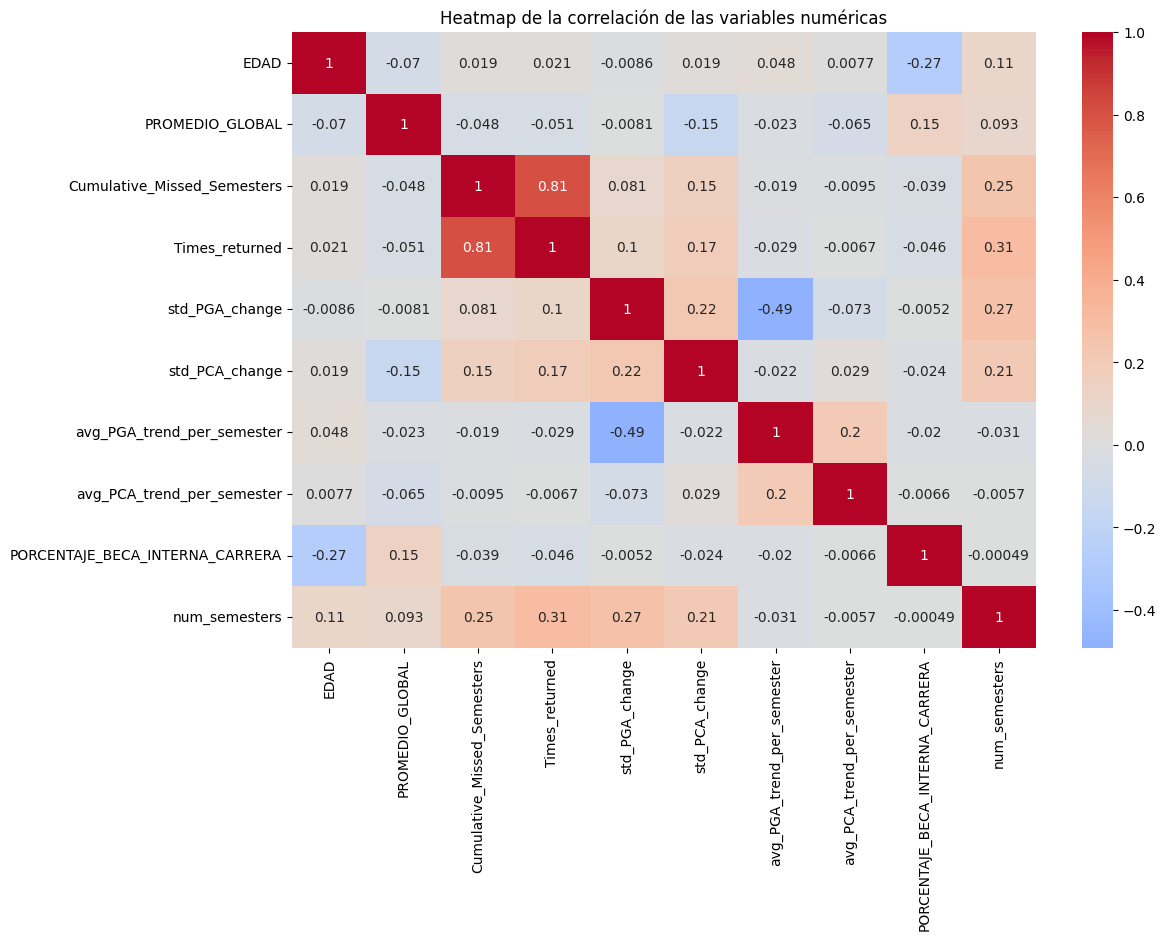

In [192]:
# Select only the numeric columns
numeric_columns = X_train.select_dtypes(include='number')

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap de la correlación de las variables numéricas')
plt.show()


Se eliminan las columnas en las que se observa una muy alta correlación para que no haya multicolinealidad

In [ ]:
X_train.drop(columns=["PROMEDIO_GLOBAL_min", "PROMEDIO_GLOBAL_max", "PCA_min", "PCA_max", "YEAR_GRADUATION", "PCA", "TIPO_ESTADO_CIVIL"], inplace=True)
X_test.drop(columns=["PROMEDIO_GLOBAL_min", "PROMEDIO_GLOBAL_max", "PCA_min", "PCA_max", "YEAR_GRADUATION", "PCA", "TIPO_ESTADO_CIVIL"], inplace=True)

Se verifica una última vez la correlación entre las variables

In [ ]:
# Select only the numeric columns
numeric_columns = X_train.select_dtypes(include='number')

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Heatmap de la correlación de las variables numéricas')
plt.show()

### Random Forest

In [193]:
# Define numerical and categorical variables
num_var = X_train.select_dtypes(include=['number']).columns.tolist()
cat_var = X_train.select_dtypes(include=['object']).columns.tolist()

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_var),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_var)
    ]
)

# Define pipeline parameters
parameter = {
    "classifier__n_estimators": [100, 200, 300, 400, 500],
    "classifier__criterion": ["gini", "entropy"],
    "classifier__max_depth": [10, 20, 30, 40, 50]
}

# Create pipeline with SMOTE
pipe_lr_l1 = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(class_weight="balanced"))
])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Create grid search
grid_pipeline_rf = GridSearchCV(pipe_lr_l1, param_grid=parameter, cv=cv, verbose=2, scoring="f1")

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Transform Y_train and Y_test
Y_train_encoded = label_encoder.fit_transform(Y_train)

# Fit grid search
grid_pipeline_rf.fit(X_train, Y_train_encoded)

# Get best estimator and parameters
best_model_rf = grid_pipeline_rf.best_estimator_
best_params_rf = grid_pipeline_rf.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__n_estimators=100; total time=   0.9s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__n_estimators=100; total time=   0.7s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__n_estimators=200; total time=   1.4s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__n_estimators=200; total time=   1.4s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__n_estimators=200; total time=   1.3s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__n_estimators=300; total time=   2.0s
[CV] END classifier__criterion=gini, classifier__max_depth=10, classifier__n_estimators=300; total time=   1.9s
[CV] END classifier__criterion=gini, class

In [194]:
best_model_rf

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['EDAD', 'PROMEDIO_GLOBAL',
                                                   'Cumulative_Missed_Semesters',
                                                   'Times_returned',
                                                   'std_PGA_change',
                                                   'std_PCA_change',
                                                   'avg_PGA_trend_per_semester',
                                                   'avg_PCA_trend_per_semester',
                                                   'PORCENTAJE_BECA_INTERNA_CARRERA',
                                                   'num_semesters']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['FACULTAD_PROGRAMA_1',
                                                   'DEPARTAMENTO_RESIDENCIA_UG',
                                                   'CLASIFICACION_BECAS'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=40,
                                        n_estimators=500))])

In [195]:
best_params_rf

{'classifier__criterion': 'entropy',
 'classifier__max_depth': 40,
 'classifier__n_estimators': 500}

In [196]:
print("El mejor resultado de train es:")
grid_pipeline_rf.best_score_

El mejor resultado de train es:


np.float64(0.9405315280994021)

In [197]:
y_pred = best_model_rf.predict(X_train)
print(classification_report(Y_train_encoded, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1192
           1       1.00      1.00      1.00     10052

    accuracy                           1.00     11244
   macro avg       1.00      1.00      1.00     11244
weighted avg       1.00      1.00      1.00     11244



In [ ]:
Y_test_encoded = label_encoder.transform(Y_test)

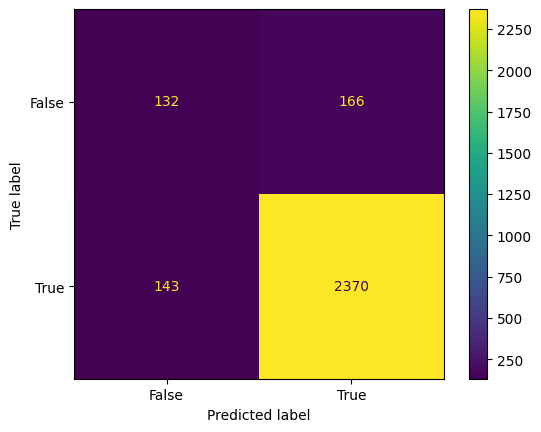

In [199]:
predict_test_rf = best_model_rf.predict(X_test)
confusion_matrix_rf = confusion_matrix(Y_test_encoded, predict_test_rf)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix_rf, display_labels = [False, True])
cm_display.plot()

In [ ]:
rf_precision = precision_score(Y_test_encoded, predict_test_rf)
rf_recall = recall_score(Y_test_encoded, predict_test_rf)
rf_f1 = 2 * (rf_precision * rf_recall) / (rf_precision + rf_recall)
rf_accuracy = accuracy_score(Y_test_encoded, predict_test_rf)
print("Precision:", precision_score(Y_test_encoded, predict_test_rf))
print("Recall:", recall_score(Y_test_encoded, predict_test_rf))
print("F1-Score:", rf_f1)
print("Accuracy:", rf_accuracy)

Precision: 0.9345425867507886
Recall: 0.9430959013131716
F1-Score: 0.9387997623291742
Accuracy: 0.8900747065101388


In [ ]:
print(classification_report(Y_test_encoded, predict_test_rf))

              precision    recall  f1-score   support

           0       0.48      0.44      0.46       298
           1       0.93      0.94      0.94      2513

    accuracy                           0.89      2811
   macro avg       0.71      0.69      0.70      2811
weighted avg       0.89      0.89      0.89      2811



                                              Feature  Importance
1                                     PROMEDIO_GLOBAL    0.232588
9                                       num_semesters    0.161302
0                                                EDAD    0.157361
6                          avg_PGA_trend_per_semester    0.098774
4                                      std_PGA_change    0.053406
7                          avg_PCA_trend_per_semester    0.035550
21                     FACULTAD_PROGRAMA_1_INGENIERÍA    0.025148
10                 FACULTAD_PROGRAMA_1_ADMINISTRACIÓN    0.021515
8                     PORCENTAJE_BECA_INTERNA_CARRERA    0.021232
27           CLASIFICACION_BECAS_OTRAS FORMAS DE PAGO    0.016461
5                                      std_PCA_change    0.015880
25                 CLASIFICACION_BECAS_BECAS EXTERNAS    0.014252
17                        FACULTAD_PROGRAMA_1_DERECHO    0.014209
14                          FACULTAD_PROGRAMA_1_CIDER    0.013974
24   DEPAR

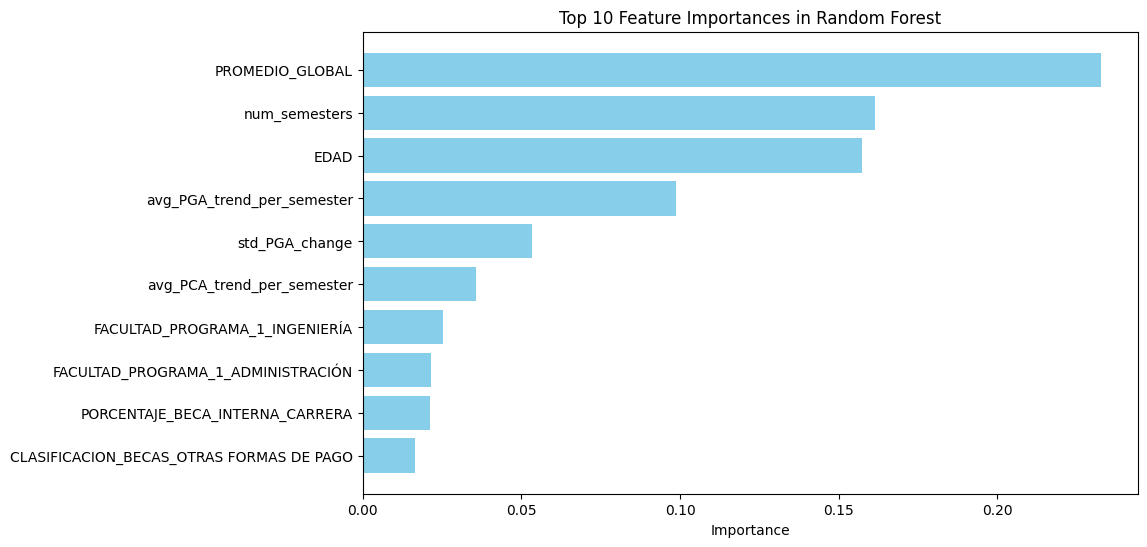

In [202]:
# Get the trained Random Forest classifier from the pipeline
rf_model = best_model_rf.named_steps['classifier']

# Retrieve the feature names from the preprocessor
feature_names = np.array(
    num_var + 
    list(best_model_rf.named_steps['preprocessor']
         .named_transformers_['cat']
         .get_feature_names_out(cat_var))
)

# Get feature importances
importances = rf_model.feature_importances_

# Combine feature names and importances
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort features by importance
feature_importances = feature_importances.sort_values(by="Importance", ascending=False)

# Display the top 10 features
print(feature_importances)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'][:10], feature_importances['Importance'][:10], color='skyblue')
plt.gca().invert_yaxis()  # Highest importance on top
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances in Random Forest')
plt.show()


### SVM

In [203]:
# Define numerical and categorical variables
num_var = X_train.select_dtypes(include=['number']).columns.tolist()
cat_var = X_train.select_dtypes(include=['object']).columns.tolist()

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_var),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_var)
    ]
)

# Define pipeline parameters
parameter = {
    "classifier__C": [0.1, 0.5, 0.8, 1, 2],
    "classifier__degree": [1,2,3],
    "classifier__kernel": ["poly", "rbf", "sigmoid", "linear", "precomputed"],
}

# Create pipeline with SMOTE
pipe_lr_l1 = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', SVC())
])

# Create grid search
grid_pipeline_svm = GridSearchCV(pipe_lr_l1, param_grid=parameter, cv=3, verbose=2, scoring="f1")

# Initialize the LabelEncoder
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)

# Fit grid search
grid_pipeline_svm.fit(X_train, Y_train_encoded)

# Get best estimator and parameters
best_model_svm = grid_pipeline_svm.best_estimator_
best_params_svm = grid_pipeline_svm.best_params_

Fitting 3 folds for each of 75 candidates, totalling 225 fits
[CV] END classifier__C=0.1, classifier__degree=1, classifier__kernel=poly; total time=   2.6s
[CV] END classifier__C=0.1, classifier__degree=1, classifier__kernel=poly; total time=   2.6s
[CV] END classifier__C=0.1, classifier__degree=1, classifier__kernel=poly; total time=   2.5s
[CV] END classifier__C=0.1, classifier__degree=1, classifier__kernel=rbf; total time=   3.5s
[CV] END classifier__C=0.1, classifier__degree=1, classifier__kernel=rbf; total time=   3.8s
[CV] END classifier__C=0.1, classifier__degree=1, classifier__kernel=rbf; total time=   3.7s
[CV] END classifier__C=0.1, classifier__degree=1, classifier__kernel=sigmoid; total time=   5.6s
[CV] END classifier__C=0.1, classifier__degree=1, classifier__kernel=sigmoid; total time=   4.3s
[CV] END classifier__C=0.1, classifier__degree=1, classifier__kernel=sigmoid; total time=   4.8s
[CV] END classifier__C=0.1, classifier__degree=1, classifier__kernel=linear; total tim

/Users/mariacatalinaibanezpineres/Desktop/MAESTRIA/2024-20/Ciencia de Datos Aplicada/Proyecto-CDA/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
45 fits failed out of a total of 225.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/mariacatalinaibanezpineres/Desktop/MAESTRIA/2024-20/Ciencia de Datos Aplicada/Proyecto-CDA/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mariacatalinaibanezpineres/Desktop/MAESTRIA/2024-20/Ciencia de Datos Aplicada/Proyecto-CDA/venv/lib/python3.11/site-

In [204]:
best_model_svm

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['EDAD', 'PROMEDIO_GLOBAL',
                                                   'Cumulative_Missed_Semesters',
                                                   'Times_returned',
                                                   'std_PGA_change',
                                                   'std_PCA_change',
                                                   'avg_PGA_trend_per_semester',
                                                   'avg_PCA_trend_per_semester',
                                                   'PORCENTAJE_BECA_INTERNA_CARRERA',
                                                   'num_semesters']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['FACULTAD_PROGRAMA_1',
                                                   'DEPARTAMENTO_RESIDENCIA_UG',
                                                   'CLASIFICACION_BECAS'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier', SVC(C=0.1, kernel='poly'))])

In [205]:
best_params_svm 

{'classifier__C': 0.1, 'classifier__degree': 3, 'classifier__kernel': 'poly'}

In [206]:
y_pred_svm = best_model_svm.predict(X_train)
print(classification_report(Y_train_encoded, y_pred_svm))

              precision    recall  f1-score   support

           0       0.43      0.59      0.50      1192
           1       0.95      0.91      0.93     10052

    accuracy                           0.87     11244
   macro avg       0.69      0.75      0.71     11244
weighted avg       0.89      0.87      0.88     11244



In [207]:
predict_test_svm = best_model_svm.predict(X_test)
print(classification_report(Y_test_encoded, predict_test_svm))

              precision    recall  f1-score   support

           0       0.39      0.53      0.45       298
           1       0.94      0.90      0.92      2513

    accuracy                           0.86      2811
   macro avg       0.67      0.71      0.69      2811
weighted avg       0.88      0.86      0.87      2811



### AdaBoost

In [208]:
# Define numerical and categorical variables
num_var = X_train.select_dtypes(include=['number']).columns.tolist()
cat_var = X_train.select_dtypes(include=['object']).columns.tolist()

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_var),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_var)
    ]
)

# Define pipeline parameters
classifiers_with_depth = [DecisionTreeClassifier(max_depth=20, criterion="gini", min_samples_split=s) for s in [2,6,10]]
parameter = {
    "classifier__estimator":  classifiers_with_depth,
    "classifier__n_estimators": [200, 300, 400, 500],
    "classifier__learning_rate": [0.1, 0.5, 1, 2],
}

# Create pipeline with SMOTE
pipe_lr_l1 = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', AdaBoostClassifier(algorithm="SAMME"))
])

# Create grid search
grid_pipeline_ab = GridSearchCV(pipe_lr_l1, param_grid=parameter, cv=3, verbose=2, scoring="f1")

# Initialize the LabelEncoder
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)

# Fit grid search
grid_pipeline_ab.fit(X_train, Y_train_encoded)

# Get best estimator and parameters
best_model_ab = grid_pipeline_ab.best_estimator_
best_params_ab = grid_pipeline_ab.best_params_

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END classifier__estimator=DecisionTreeClassifier(max_depth=20), classifier__learning_rate=0.1, classifier__n_estimators=200; total time=  12.6s
[CV] END classifier__estimator=DecisionTreeClassifier(max_depth=20), classifier__learning_rate=0.1, classifier__n_estimators=200; total time=  12.9s
[CV] END classifier__estimator=DecisionTreeClassifier(max_depth=20), classifier__learning_rate=0.1, classifier__n_estimators=200; total time=  13.4s
[CV] END classifier__estimator=DecisionTreeClassifier(max_depth=20), classifier__learning_rate=0.1, classifier__n_estimators=300; total time=  18.8s
[CV] END classifier__estimator=DecisionTreeClassifier(max_depth=20), classifier__learning_rate=0.1, classifier__n_estimators=300; total time=  20.4s
[CV] END classifier__estimator=DecisionTreeClassifier(max_depth=20), classifier__learning_rate=0.1, classifier__n_estimators=300; total time=  20.6s
[CV] END classifier__estimator=DecisionTreeC

In [209]:
best_model_ab

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['EDAD', 'PROMEDIO_GLOBAL',
                                                   'Cumulative_Missed_Semesters',
                                                   'Times_returned',
                                                   'std_PGA_change',
                                                   'std_PCA_change',
                                                   'avg_PGA_trend_per_semester',
                                                   'avg_PCA_trend_per_semester',
                                                   'PORCENTAJE_BECA_INTERNA_CARRERA',
                                                   'num_semesters']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['FACULTAD_PROGRAMA_1',
                                                   'DEPARTAMENTO_RESIDENCIA_UG',
                                                   'CLASIFICACION_BECAS'])])),
                ('smote', SMOTE(random_state=42)),
                ('classifier',
                 AdaBoostClassifier(algorithm='SAMME',
                                    estimator=DecisionTreeClassifier(max_depth=20,
                                                                     min_samples_split=10),
                                    learning_rate=0.1, n_estimators=500))])

In [210]:
best_params_ab

{'classifier__estimator': DecisionTreeClassifier(max_depth=20, min_samples_split=10),
 'classifier__learning_rate': 0.1,
 'classifier__n_estimators': 500}

In [211]:
y_pred_ab = best_model_ab.predict(X_train)
print(classification_report(Y_train_encoded, y_pred_ab))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1192
           1       1.00      1.00      1.00     10052

    accuracy                           1.00     11244
   macro avg       1.00      1.00      1.00     11244
weighted avg       1.00      1.00      1.00     11244



In [212]:
predict_test_ab = best_model_ab.predict(X_test)
print(classification_report(Y_test_encoded, predict_test_ab))

              precision    recall  f1-score   support

           0       0.53      0.40      0.45       298
           1       0.93      0.96      0.94      2513

    accuracy                           0.90      2811
   macro avg       0.73      0.68      0.70      2811
weighted avg       0.89      0.90      0.89      2811



### Logistic Regression

In [213]:
# Define numerical and categorical variables
num_var = X_train.select_dtypes(include=['number']).columns.tolist()
cat_var = X_train.select_dtypes(include=['object']).columns.tolist()

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_var),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_var)
    ]
)

# Define pipeline parameters
parameter = {
    "classifier__C": [0.1, 0.5, 0.8, 1, 2],
    "classifier__penalty": ['l1', 'l2', 'elasticnet', None],
    "polynomial__degree": [1],
}

# Create pipeline with SMOTE
pipe_lr_l1 = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('polynomial', PolynomialFeatures()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression())
])

# Create grid search
grid_pipeline_lr = GridSearchCV(pipe_lr_l1, param_grid=parameter, cv=3, verbose=2, scoring="f1")

# Initialize the LabelEncoder
label_encoder = LabelEncoder()
Y_train_encoded = label_encoder.fit_transform(Y_train)

# Fit grid search
grid_pipeline_lr.fit(X_train, Y_train_encoded)

# Get best estimator and parameters
best_model_lr = grid_pipeline_lr.best_estimator_
best_params_lr = grid_pipeline_lr.best_params_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END classifier__C=0.1, classifier__penalty=l1, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__penalty=l1, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__penalty=l1, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__penalty=l2, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__penalty=l2, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__penalty=l2, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__penalty=elasticnet, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__penalty=elasticnet, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__penalty=elasticnet, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.1, classifier__penalty=None, polynomial__degree=1; to

/Users/mariacatalinaibanezpineres/Desktop/MAESTRIA/2024-20/Ciencia de Datos Aplicada/Proyecto-CDA/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/mariacatalinaibanezpineres/Desktop/MAESTRIA/2024-20/Ciencia de Datos Aplicada/Proyecto-CDA/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/mariacatalinaibanezpineres/Desktop/MAESTRIA/2024-20/Ciencia de Datos Aplicada/Proyecto-CDA/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=0.5, classifier__penalty=l2, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.5, classifier__penalty=l2, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.5, classifier__penalty=elasticnet, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.5, classifier__penalty=elasticnet, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.5, classifier__penalty=elasticnet, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.5, classifier__penalty=None, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.5, classifier__penalty=None, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.5, classifier__penalty=None, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.8, classifier__penalty=l1, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.8, classifier__penalty=l1, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.8, classifier__

/Users/mariacatalinaibanezpineres/Desktop/MAESTRIA/2024-20/Ciencia de Datos Aplicada/Proyecto-CDA/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/mariacatalinaibanezpineres/Desktop/MAESTRIA/2024-20/Ciencia de Datos Aplicada/Proyecto-CDA/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/mariacatalinaibanezpineres/Desktop/MAESTRIA/2024-20/Ciencia de Datos Aplicada/Proyecto-CDA/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=0.8, classifier__penalty=l2, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.8, classifier__penalty=l2, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.8, classifier__penalty=l2, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.8, classifier__penalty=elasticnet, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.8, classifier__penalty=elasticnet, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.8, classifier__penalty=elasticnet, polynomial__degree=1; total time=   0.0s


/Users/mariacatalinaibanezpineres/Desktop/MAESTRIA/2024-20/Ciencia de Datos Aplicada/Proyecto-CDA/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/mariacatalinaibanezpineres/Desktop/MAESTRIA/2024-20/Ciencia de Datos Aplicada/Proyecto-CDA/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/mariacatalinaibanezpineres/Desktop/MAESTRIA/2024-20/Ciencia de Datos Aplicada/Proyecto-CDA/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV] END classifier__C=0.8, classifier__penalty=None, polynomial__degree=1; total time=   0.1s
[CV] END classifier__C=0.8, classifier__penalty=None, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=0.8, classifier__penalty=None, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=1, classifier__penalty=l1, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=1, classifier__penalty=l1, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=1, classifier__penalty=l1, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=1, classifier__penalty=l2, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=1, classifier__penalty=l2, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=1, classifier__penalty=l2, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=1, classifier__penalty=elasticnet, polynomial__degree=1; total time=   0.0s
[CV] END classifier__C=1, classifier__penalty=elasticnet, polynomial__

/Users/mariacatalinaibanezpineres/Desktop/MAESTRIA/2024-20/Ciencia de Datos Aplicada/Proyecto-CDA/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/mariacatalinaibanezpineres/Desktop/MAESTRIA/2024-20/Ciencia de Datos Aplicada/Proyecto-CDA/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/mariacatalinaibanezpineres/Desktop/MAESTRIA/2024-20/Ciencia de Datos Aplicada/Proyecto-CDA/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/mariacatalinaibanezpineres/Desktop/MAESTRIA/2024-20/Ciencia de Datos Aplicada/Proyecto-CDA/venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
30 fits fa

In [214]:
best_model_lr

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['EDAD', 'PROMEDIO_GLOBAL',
                                                   'Cumulative_Missed_Semesters',
                                                   'Times_returned',
                                                   'std_PGA_change',
                                                   'std_PCA_change',
                                                   'avg_PGA_trend_per_semester',
                                                   'avg_PCA_trend_per_semester',
                                                   'PORCENTAJE_BECA_INTERNA_CARRERA',
                                                   'num_semesters']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['FACULTAD_PROGRAMA_1',
                                                   'DEPARTAMENTO_RESIDENCIA_UG',
                                                   'CLASIFICACION_BECAS'])])),
                ('polynomial', PolynomialFeatures(degree=1)),
                ('smote', SMOTE(random_state=42)),
                ('classifier', LogisticRegression(C=0.8))])

In [215]:
best_params_lr

{'classifier__C': 0.8, 'classifier__penalty': 'l2', 'polynomial__degree': 1}

In [216]:
y_pred_lr = best_model_lr.predict(X_train)
print(classification_report(Y_train_encoded, y_pred_lr))

              precision    recall  f1-score   support

           0       0.28      0.72      0.40      1192
           1       0.96      0.78      0.86     10052

    accuracy                           0.77     11244
   macro avg       0.62      0.75      0.63     11244
weighted avg       0.89      0.77      0.81     11244



In [217]:
X_test, Y_test = test.drop([target_feature], axis=1), test[target_feature]
Y_test_encoded = label_encoder.transform(Y_test)

In [218]:
predict_test_lr = best_model_lr.predict(X_test)
print(classification_report(Y_test_encoded, predict_test_lr))

              precision    recall  f1-score   support

           0       0.28      0.73      0.40       298
           1       0.96      0.77      0.86      2513

    accuracy                           0.77      2811
   macro avg       0.62      0.75      0.63      2811
weighted avg       0.89      0.77      0.81      2811

